In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [4, 3]

import MDAnalysis
from MDAnalysis.analysis import *
import mdtraj as mdt
import pandas as pd
from scipy.optimize import minimize
from scipy import stats
from scipy.ndimage import uniform_filter1d

from sklearn.decomposition import PCA
from bussilab import clustering

import plumed as plu

import copy
import os
import pickle
from time import time
import datetime

import itertools

from pyvis import network as net
from pyvis import options as opt
import networkx as nx

/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/python3.10/site-packages/MDAnalysis/analysis/data/filenames.py:110: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename
/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/python3.10/site-packages/MDAnalysis/analysis/hbonds/hbond_autocorrel.py:52: DeprecationWarning: This module was moved to MDAnalysis.analysis.hydrogenbonds.hbond_autocorrel; hbonds.hbond_autocorrel will be removed in 3.0.0.
  warnings.warn(wmsg, category=DeprecationWarning)
/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/python3.10/site-packages/bussilab/coretools.py:42: UserWarning: There was a problem importing numba, jit functions will work but will be MUCH slower.
  warnings.warn("There was a problem importing numba, jit functions will work but will be MUCH slower.")


In [2]:
plt.style.use('tableau-colorblind10')

In [3]:
path='./input/'
path_out='./output_check/'
exp_whole=np.loadtxt(path+'SASDQT9_RAD51-BRC4.dat')

In [4]:
# Guinnier experimental for Rg
slope, intercept, r_value, p_value, std_err = stats.linregress(
    exp_whole[48:310,0]**2,
    np.log(exp_whole[48:310,1]))
print('Guinier fit Rg:',np.sqrt(-3*slope))

Guinier fit Rg: 28.600869618541104


In [5]:
shift=48
selected_points=np.argmin((np.linspace(0.01,0.27,27).reshape(-1,1)-exp_whole[48:2056,0])**2,axis=1)+shift

In [6]:
uf_exp_whole=uniform_filter1d(exp_whole[:,1], size=51,mode='reflect')
uf_exp_whole.shape

(2569,)

In [7]:
print("SCALE_EXPINT="+str(np.exp(intercept)))
for i in range(len(selected_points)):
    print("QVALUE"+str(int(i+1))+'='+str(exp_whole[selected_points[i],0])+' '+"EXPINT"+str(int(i+1))+"="+str(uf_exp_whole[selected_points[i]]))

SCALE_EXPINT=0.03308254964675395
QVALUE1=0.01077103 EXPINT1=0.032496143921568625
QVALUE2=0.02004692 EXPINT2=0.029574363529411757
QVALUE3=0.02997605 EXPINT3=0.02573280137254901
QVALUE4=0.04003583 EXPINT4=0.021387183333333313
QVALUE5=0.04996495 EXPINT5=0.017315874509803902
QVALUE6=0.06002473 EXPINT6=0.013607859411764688
QVALUE7=0.06995385 EXPINT7=0.010560911352941158
QVALUE8=0.08001363 EXPINT8=0.007967748960784298
QVALUE9=0.08994276 EXPINT9=0.006012438235294102
QVALUE10=0.1000025 EXPINT10=0.004477551431372533
QVALUE11=0.1100623 EXPINT11=0.003312513862745081
QVALUE12=0.1199914 EXPINT12=0.00240160503921567
QVALUE13=0.1300512 EXPINT13=0.0017190352549019455
QVALUE14=0.1399803 EXPINT14=0.0011963419411764554
QVALUE15=0.1500401 EXPINT15=0.0008124202607842982
QVALUE16=0.1599692 EXPINT16=0.0006005266058823376
QVALUE17=0.170029 EXPINT17=0.0004546479431372395
QVALUE18=0.1799581 EXPINT18=0.0003499681941176316
QVALUE19=0.1900179 EXPINT19=0.00030712468627449425
QVALUE20=0.199947 EXPINT20=0.00024375893

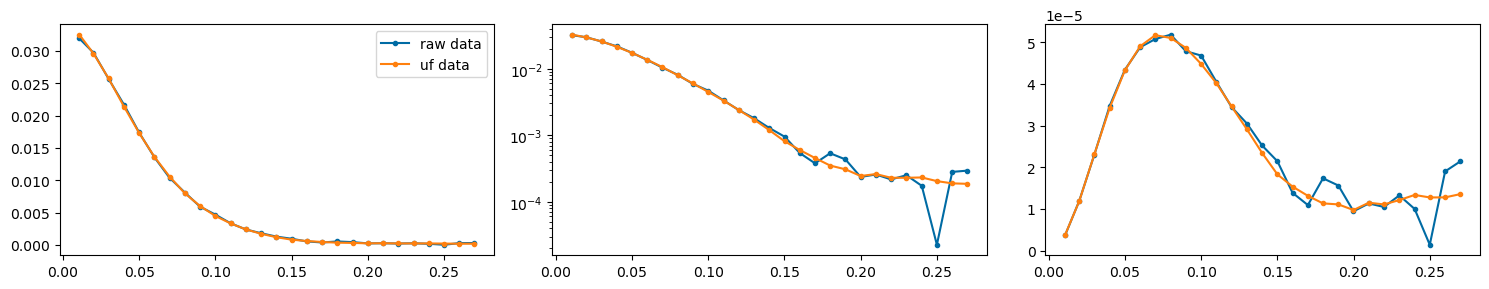

In [8]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(exp_whole[selected_points,0],exp_whole[selected_points,1],'.-',label='raw data')
plt.plot(exp_whole[selected_points,0],uf_exp_whole[selected_points],'.-',label='uf data')
plt.legend()
plt.subplot(1,3,2)
plt.plot(exp_whole[selected_points,0],exp_whole[selected_points,1],'.-',label='raw data')
plt.plot(exp_whole[selected_points,0],uf_exp_whole[selected_points],'.-',label='uf data')
plt.yscale('log')
plt.subplot(1,3,3)
plt.plot(exp_whole[selected_points,0],exp_whole[selected_points,1]*exp_whole[selected_points,0]**2,'.-',label='raw data')
plt.plot(exp_whole[selected_points,0],uf_exp_whole[selected_points]*exp_whole[selected_points,0]**2,'.-',label='uf data')
plt.tight_layout()
plt.show()

## SteeredMD:

In [9]:
exp_spectrum=np.loadtxt(path+'SASDQT9_RAD51-BRC4.dat',comments=['#','@'])

In [10]:
colv_m1=plu.read_as_pandas(path+'colvar_steered_m_1')
colv_m2=plu.read_as_pandas(path+'colvar_steered_m_2')
colv_m3=plu.read_as_pandas(path+'colvar_steered_m_3')

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/libplumedKernel.so" +++


In [11]:
colv_m1_np=np.loadtxt(path+'colvar_steered_m_1',skiprows=1)
colv_m2_np=np.loadtxt(path+'colvar_steered_m_2',skiprows=1)
colv_m3_np=np.loadtxt(path+'colvar_steered_m_3',skiprows=1)

In [12]:
qs_mart_file="""QVALUE1=0.0101178 EXPINT1=0.03268278549019608
QVALUE2=0.02004692 EXPINT2=0.029574363529411757
QVALUE3=0.02997605 EXPINT3=0.02573280137254901
QVALUE4=0.03990518 EXPINT4=0.021441139215686255
QVALUE5=0.04996495 EXPINT5=0.017315874509803902
QVALUE6=0.06002473 EXPINT6=0.013607859411764688
QVALUE7=0.06995385 EXPINT7=0.010560911352941158
QVALUE8=0.08001363 EXPINT8=0.007967748960784298
QVALUE9=0.08994276 EXPINT9=0.006012438235294102
QVALUE10=0.1000025 EXPINT10=0.004477551431372533
QVALUE11=0.1199914 EXPINT11=0.00240160503921567
QVALUE12=0.1399803 EXPINT12=0.0011963419411764554
QVALUE13=0.1599692 EXPINT13=0.0006005266058823376
QVALUE14=0.1799581 EXPINT14=0.0003499681941176316
QVALUE15=0.199947 EXPINT15=0.00024375893686272957
QVALUE16=0.2200666 EXPINT16=0.00023157075156861204
QVALUE17=0.2400555 EXPINT17=0.0002318339798039062
QVALUE18=0.2600444 EXPINT18=0.00018894343299998486
QVALUE19=0.2800333 EXPINT19=0.00017391225274508286
"""

In [13]:
qs_mart=np.array([a.split(sep='=') for a in np.array(qs_mart_file.split())[::2]])[:,1].astype(float)

In [14]:
exp_saxs=np.array([a.split(sep='=') for a in np.array(qs_mart_file.split())[1::2]])[:,1].astype(float)

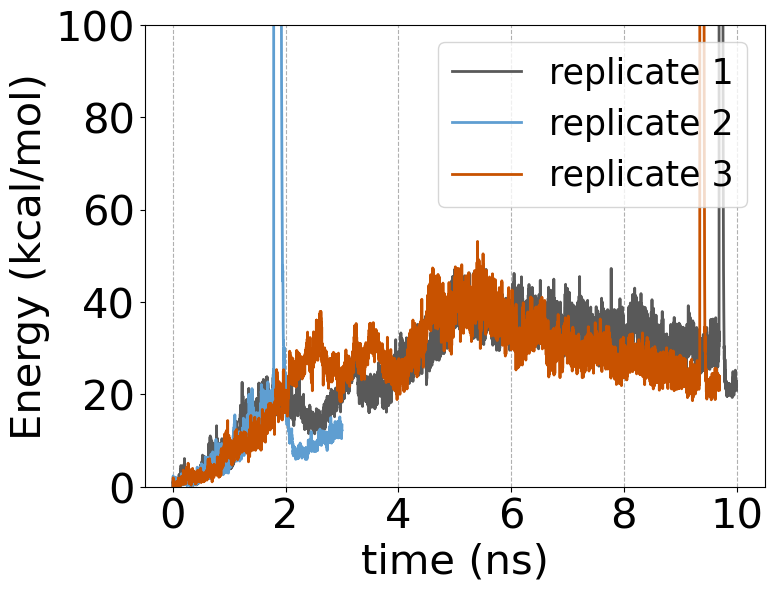

In [178]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(8,6))
plt.ylim(0,100)
plt.ylabel('Energy (kcal/mol)',fontsize=30)
plt.xlabel('time (ns)',fontsize=30)
plt.xticks(fontsize=30)
#plt.tick_params(labelbottom = False, bottom = False) 
plt.yticks(np.arange(0,120,20),fontsize=30)
plt.grid(axis='x',ls='--')
plt.plot(colv_m1['time']/1000,colv_m1['steered.bias']/4.184,label='replicate 1',lw=2,color='C3')
plt.plot(colv_m2['time'][0:3000]/1000,colv_m2['steered.bias'][0:3000]/4.184,label='replicate 2',lw=2,color='C4')
plt.plot(colv_m3['time'][0:9700]/1000,colv_m3['steered.bias'][0:9700]/4.184,label='replicate 3',lw=2,color='C5')
plt.legend(fontsize=25,loc='upper right')
plt.savefig(path_out+'bias_martini_nox_energy.svg',dpi=300,bbox_inches='tight')

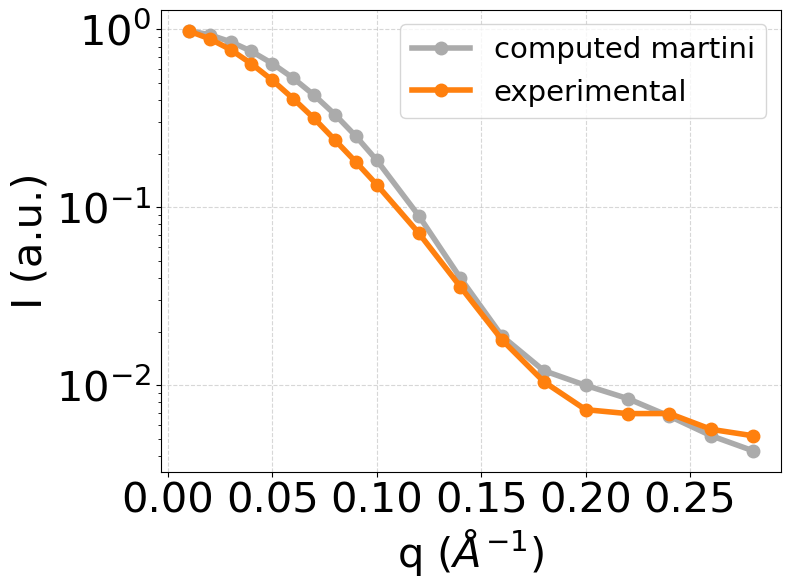

In [181]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(8,6))
plt.grid(ls='--',alpha=0.5)
plt.ylabel('I (a.u.)',fontsize=30)
plt.xlabel('q ($\AA^{-1}$)',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.tick_params(labelbottom = False, bottom = False) 
plt.plot(qs_mart,colv_m1_np[0,1:20],'.-',label='computed martini',ms=18,lw=4,color='C2')
plt.plot(qs_mart,(exp_saxs/0.033474980320492204),'.-',label='experimental',ms=18,lw=4,color='C1')
plt.yscale('log')
plt.legend(fontsize=21,loc='upper right')
plt.savefig(path_out+'log_martini_nox.svg',dpi=300,bbox_inches='tight')

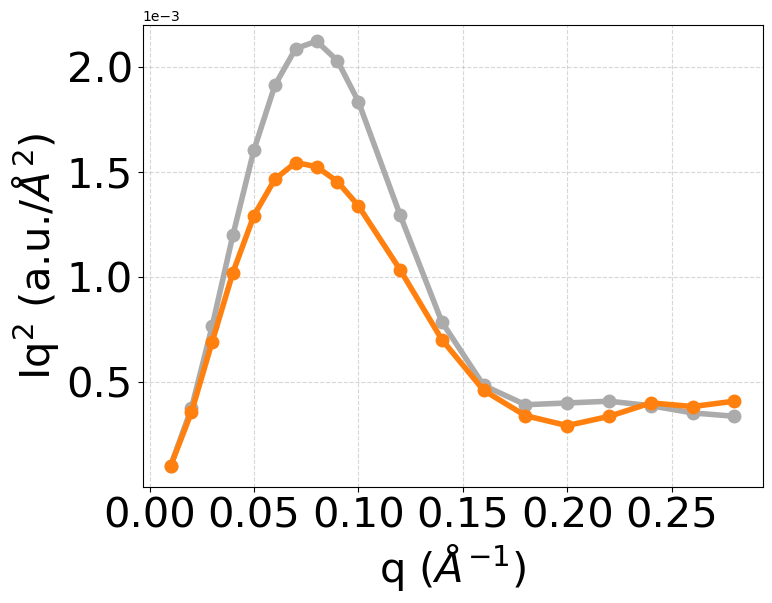

In [183]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(8,6))
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.grid(ls='--',alpha=0.5)
plt.ylabel('Iq$^2$ (a.u./$\AA^2$)',fontsize=30)
plt.xlabel('q ($\AA^{-1}$)',fontsize=30)
plt.xticks(fontsize=30)
#plt.tick_params(labelbottom = False, bottom = False) 
plt.yticks(np.arange(0.0005, 0.0025, step=0.0005),fontsize=30)
plt.ylim(0,0.0022)
plt.plot(qs_mart,colv_m1_np[0,1:20]*qs_mart**2,'.-',label='computed martini',ms=18,lw=4,color='C2')
plt.plot(qs_mart,(exp_saxs/0.033474980320492204)*qs_mart**2,'.-',label='experimental',ms=18,lw=4,color='C1')
plt.savefig(path_out+'kratky_martini_nox.svg',dpi=300,bbox_inches='tight')

In [18]:
colv_b1=plu.read_as_pandas(path+'colvar_steered_106_10ns_onebead_1')
colv_b2=plu.read_as_pandas(path+'colvar_steered_106_10ns_onebead_2')
colv_b3=plu.read_as_pandas(path+'colvar_steered_106_10ns_onebead_3')

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/libplumedKernel.so" +++


In [19]:
colv_b1_np=np.loadtxt(path+'colvar_steered_106_10ns_onebead_1',skiprows=1)
colv_b2_np=np.loadtxt(path+'colvar_steered_106_10ns_onebead_2',skiprows=1)
colv_b3_np=np.loadtxt(path+'colvar_steered_106_10ns_onebead_3',skiprows=1)

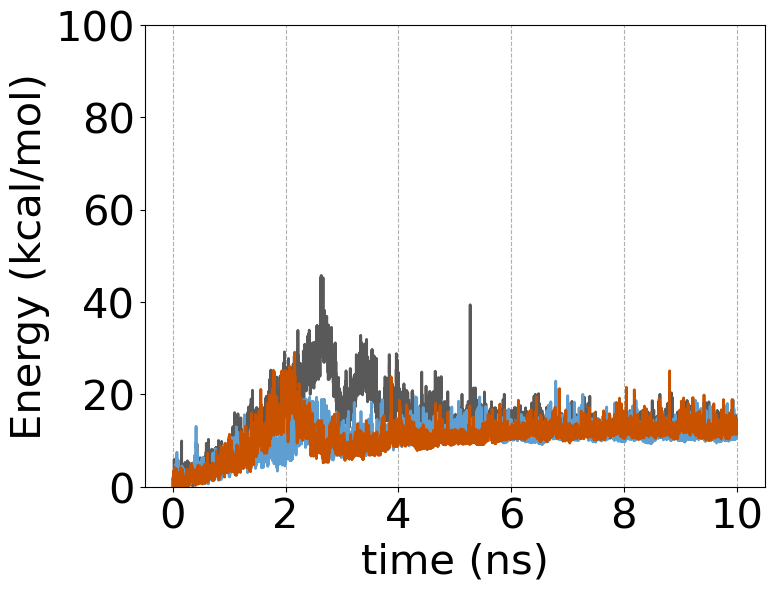

In [184]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(8,6))
plt.ylim(0,100)
plt.ylabel('Energy (kcal/mol)',fontsize=30)
plt.xlabel('time (ns)',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(np.arange(0,120,20),fontsize=30)
plt.grid(axis='x',ls='--')
plt.plot(colv_b1['time']/1000,colv_b1['steered.bias']/4.184,lw=2,color='C3') #replicate1
plt.plot(colv_b2['time']/1000,colv_b2['steered.bias']/4.184,lw=2,color='C4') #replicate2
plt.plot(colv_b3['time']/1000,colv_b3['steered.bias']/4.184,lw=2,color='C5') #replicate3
plt.savefig(path_out+'bias_1b_energy.svg',dpi=300,bbox_inches='tight')

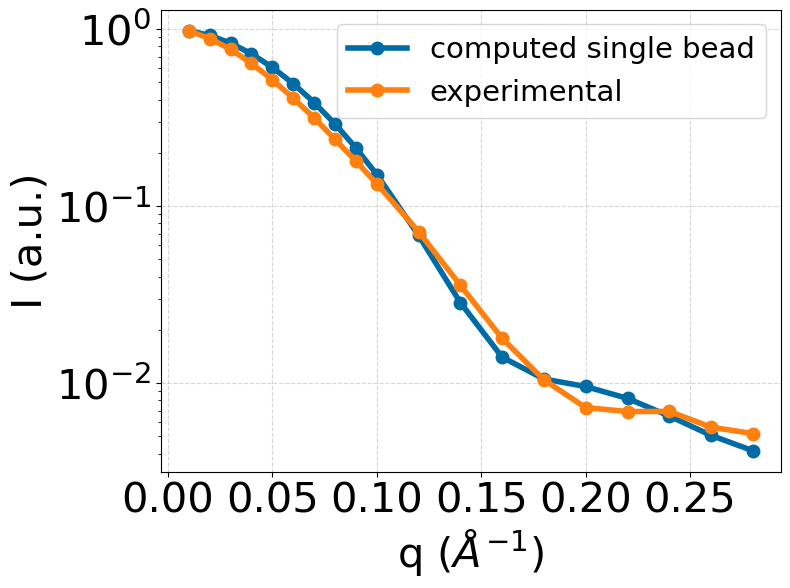

In [185]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(8,6))
plt.grid(ls='--',alpha=0.5)
plt.ylabel('I (a.u.)',fontsize=30)
plt.xlabel('q ($\AA^{-1}$)',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.plot(qs_mart,colv_b1_np[0,1:20],'.-',label='computed single bead',ms=18,lw=4)
plt.plot(qs_mart,(exp_saxs/0.033474980320492204),'.-',label='experimental',ms=18,lw=4)
plt.yscale('log')
plt.legend(fontsize=21,loc='upper right')
plt.savefig(path_out+'log_1b.svg',dpi=300,bbox_inches='tight')

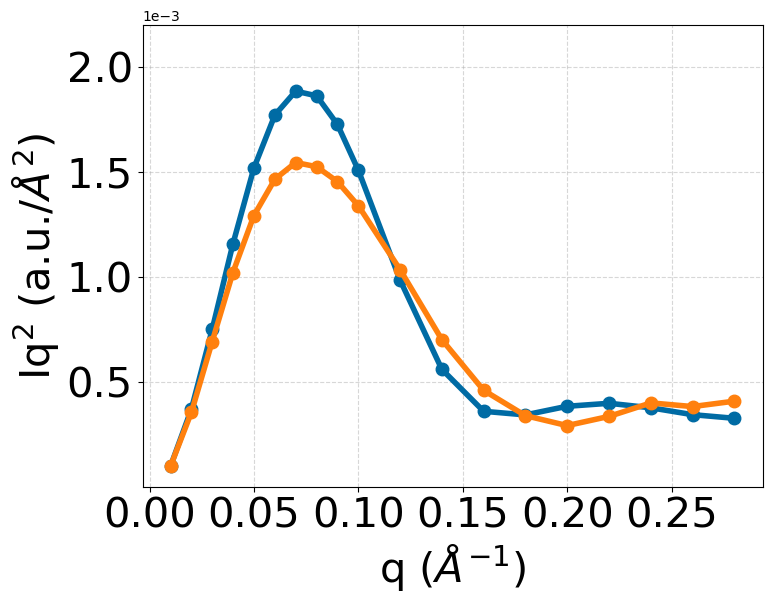

In [186]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(8,6))
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.grid(ls='--',alpha=0.5)
plt.ylabel('Iq$^2$ (a.u./$\AA^2$)',fontsize=30)
plt.xlabel('q ($\AA^{-1}$)',fontsize=30)
plt.xticks(fontsize=30)
plt.ylim(0,0.0022) 
plt.yticks(np.arange(0.0005, 0.0025, step=0.0005),fontsize=30)
plt.plot(qs_mart,colv_b1_np[0,1:20]*qs_mart**2,'.-',label='computed single bead',ms=18,lw=4)
plt.plot(qs_mart,(exp_saxs/0.033474980320492204)*qs_mart**2,'.-',label='experimental',ms=18,lw=4)
plt.savefig(path_out+'kratky_1b.svg',dpi=300,bbox_inches='tight')

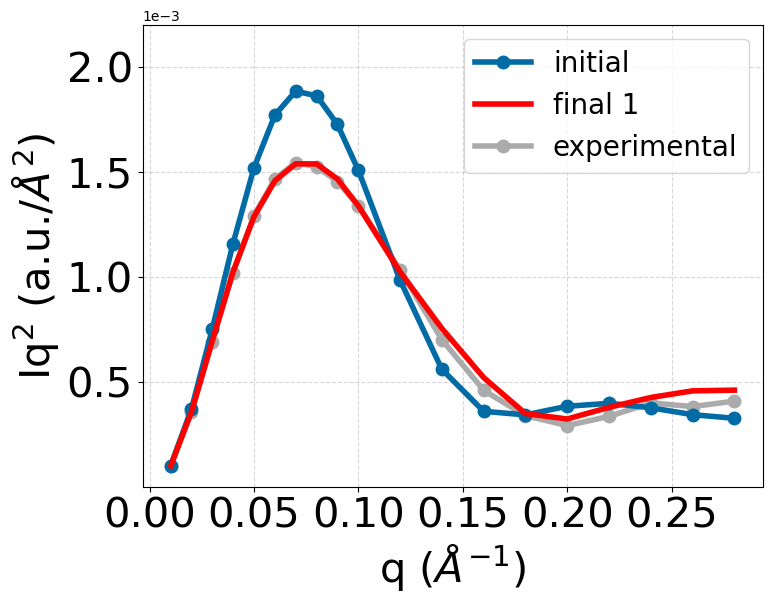

In [187]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(8,6))
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.grid(ls='--',alpha=0.5)
plt.ylabel('Iq$^2$ (a.u./$\AA^2$)',fontsize=30)
plt.xlabel('q ($\AA^{-1}$)',fontsize=30)
plt.xticks(fontsize=30)
plt.ylim(0,0.0022) 
plt.yticks(np.arange(0.0005, 0.0025, step=0.0005),fontsize=30)
plt.plot(qs_mart,colv_b1_np[0,1:20]*qs_mart**2,'.-',label='initial',ms=18,lw=4)
plt.plot(qs_mart,colv_b1_np[-1,1:20]*qs_mart**2,label='final 1',ms=18,lw=4,color='red')
plt.plot(qs_mart,(exp_saxs/0.033474980320492204)*qs_mart**2,'.-',label='experimental',ms=18,lw=4,zorder=0,color='C2')
plt.legend(fontsize=20)
plt.savefig(path_out+'kratky_1b_final_st1.svg',dpi=300,bbox_inches='tight')

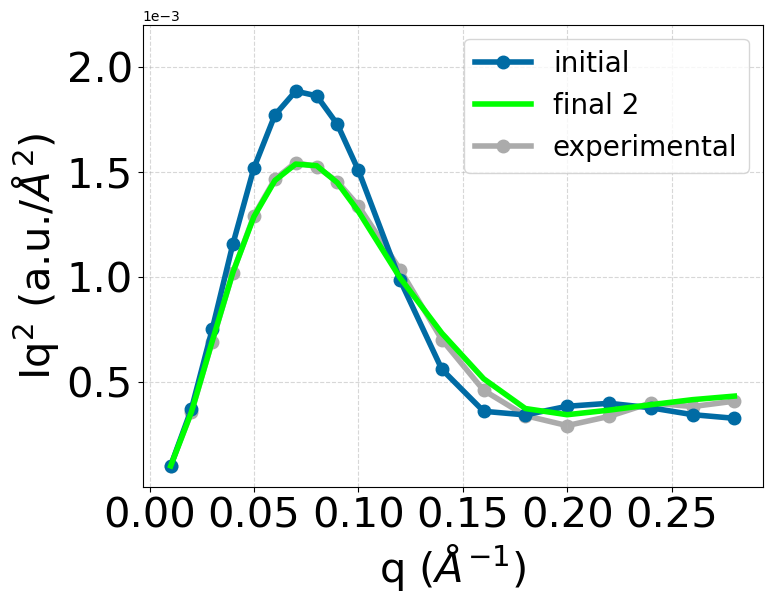

In [188]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(8,6))
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.grid(ls='--',alpha=0.5)
plt.ylabel('Iq$^2$ (a.u./$\AA^2$)',fontsize=30)
plt.xlabel('q ($\AA^{-1}$)',fontsize=30)
plt.xticks(fontsize=30)
plt.ylim(0,0.0022) 
plt.yticks(np.arange(0.0005, 0.0025, step=0.0005),fontsize=30)
plt.plot(qs_mart,colv_b1_np[0,1:20]*qs_mart**2,'.-',label='initial',ms=18,lw=4)
plt.plot(qs_mart,colv_b2_np[-1,1:20]*qs_mart**2,label='final 2',ms=18,lw=4,color='lime')
plt.plot(qs_mart,(exp_saxs/0.033474980320492204)*qs_mart**2,'.-',label='experimental',ms=18,lw=4,zorder=0,color='C2')
plt.legend(fontsize=20)
plt.savefig(path_out+'kratky_1b_final_st2.svg',dpi=300,bbox_inches='tight')

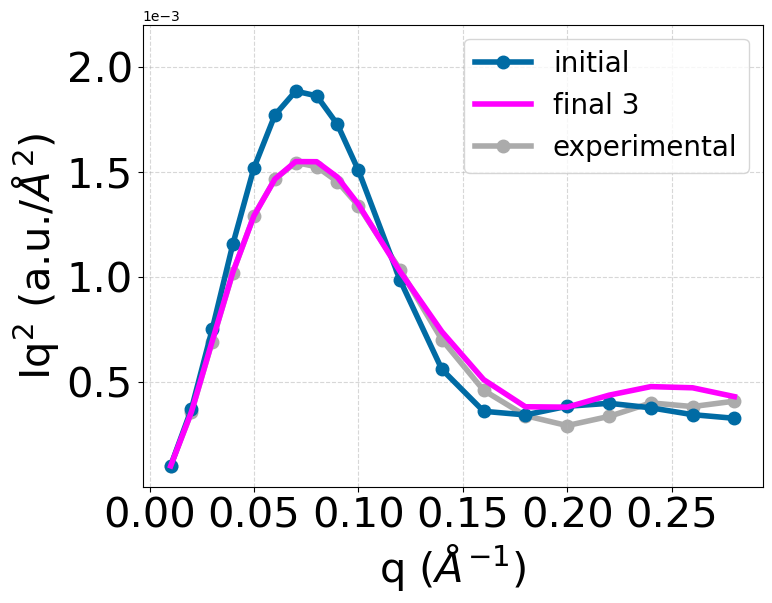

In [189]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(8,6))
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.grid(ls='--',alpha=0.5)
plt.ylabel('Iq$^2$ (a.u./$\AA^2$)',fontsize=30)
plt.xlabel('q ($\AA^{-1}$)',fontsize=30)
plt.xticks(fontsize=30)
plt.ylim(0,0.0022) 
plt.yticks(np.arange(0.0005, 0.0025, step=0.0005),fontsize=30)
plt.plot(qs_mart,colv_b1_np[0,1:20]*qs_mart**2,'.-',label='initial',ms=18,lw=4)
plt.plot(qs_mart,colv_b3_np[-1,1:20]*qs_mart**2,label='final 3',ms=18,lw=4,color='magenta')
plt.plot(qs_mart,(exp_saxs/0.033474980320492204)*qs_mart**2,'.-',label='experimental',ms=18,lw=4,zorder=0,color='C2')
plt.legend(fontsize=20)
plt.savefig(path_out+'kratky_1b_final_st3.svg',dpi=300,bbox_inches='tight')

## RMSD ##

In [26]:
martini1=MDAnalysis.Universe(path+'protein_renum.pdb',path+'fixtraj_protein_s1.xtc')
martini2=MDAnalysis.Universe(path+'protein_renum.pdb',path+'fixtraj_protein_s2.xtc')
martini3=MDAnalysis.Universe(path+'protein_renum.pdb',path+'fixtraj_protein_s3.xtc')

/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [27]:
Rm1=MDAnalysis.analysis.rms.RMSD(martini1, reference=None, ref_frame=0,
                               select='resid 100 to 340 and not name H*',
                               groupselections=['resid 341 to 379 and not name H*'])
Rm1.run()

In [28]:
Rm2=MDAnalysis.analysis.rms.RMSD(martini2, reference=None, ref_frame=0,
                               select='resid 100 to 340 and not name H*',
                               groupselections=['resid 341 to 379 and not name H*'])
Rm2.run()

In [29]:
Rm3=MDAnalysis.analysis.rms.RMSD(martini3, reference=None, ref_frame=0,
                               select='resid 100 to 340 and not name H*',
                               groupselections=['resid 341 to 379 and not name H*'])
Rm3.run()

In [30]:
rmsd_m1=Rm1.rmsd.T
rmsd_m2=Rm2.rmsd.T
rmsd_m3=Rm3.rmsd.T

/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:722: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


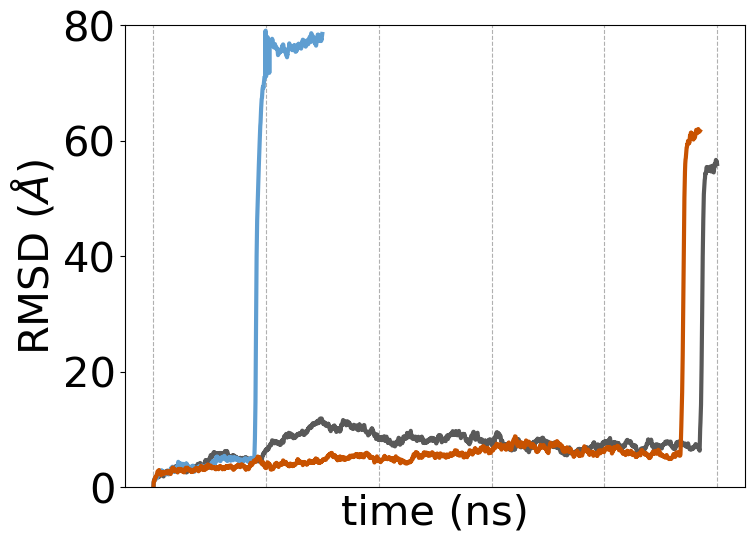

In [192]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(8,6))
plt.ylabel('RMSD ($\AA$)',fontsize=30)
plt.xlabel('time (ns)',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(np.arange(0,100,20),fontsize=30)
plt.tick_params(labelbottom = False, bottom = False)
plt.grid(axis='x',ls='--')
plt.plot(rmsd_m1[1]/1000,rmsd_m1[3],lw=3,color='C3') #replicate1
plt.plot(rmsd_m1[1][0:600]/1000,rmsd_m2[3][0:600],lw=3,color='C4') #replicate2
plt.plot(rmsd_m1[1][0:1940]/1000,rmsd_m3[3][0:1940],lw=3,color='C5') #replicate3
plt.ylim(0,80)
plt.savefig(path_out+'rmsd_martini_ph.svg',dpi=300,bbox_inches='tight')

In [32]:
bead1=MDAnalysis.Universe(path+'protein_renum.pdb',path+'fixtraj_protein_o1.xtc')
bead2=MDAnalysis.Universe(path+'protein_renum.pdb',path+'fixtraj_protein_o2.xtc')
bead3=MDAnalysis.Universe(path+'protein_renum.pdb',path+'fixtraj_protein_o3.xtc')

/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [33]:
Rb1=MDAnalysis.analysis.rms.RMSD(bead1, reference=None, ref_frame=0,
                               select='resid 100 to 340 and not name H*',
                               groupselections=['resid 341 to 379 and not name H*'])
Rb1.run()

In [34]:
Rb2=MDAnalysis.analysis.rms.RMSD(bead2, reference=None, ref_frame=0,
                               select='resid 100 to 340 and not name H*',
                               groupselections=['resid 341 to 379 and not name H*'])
Rb2.run()

In [35]:
Rb3=MDAnalysis.analysis.rms.RMSD(bead3, reference=None, ref_frame=0,
                               select='resid 100 to 340 and not name H*',
                               groupselections=['resid 341 to 379 and not name H*'])
Rb3.run()

In [36]:
rmsd_b1=Rb1.rmsd.T
rmsd_b2=Rb2.rmsd.T
rmsd_b3=Rb3.rmsd.T

/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:722: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


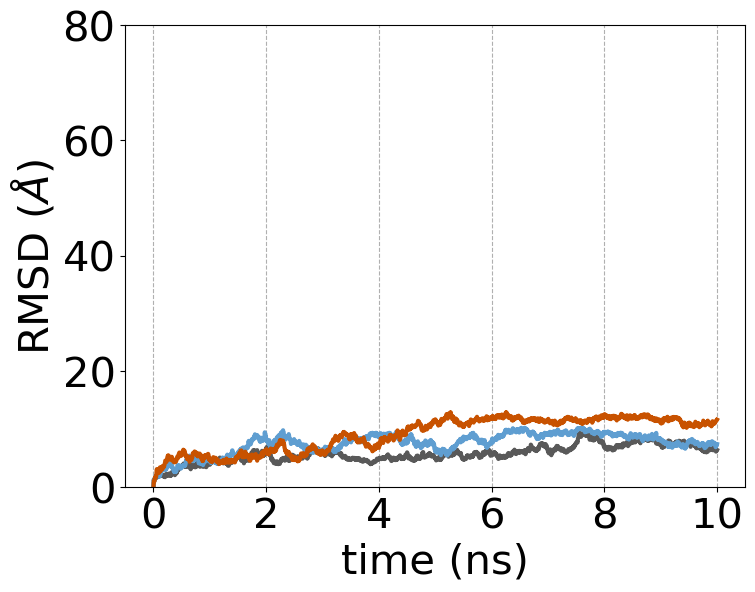

In [193]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(8,6))
plt.ylabel('RMSD ($\AA$)',fontsize=30)
plt.xlabel('time (ns)',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(np.arange(0,100,20),fontsize=30)
plt.grid(axis='x',ls='--')
plt.plot(rmsd_b1[1]/1000,rmsd_b1[3],lw=3,color='C3') #replicate1
plt.plot(rmsd_b1[1]/1000,rmsd_b2[3],lw=3,color='C4') #replicate2
plt.plot(rmsd_b1[1]/1000,rmsd_b3[3],lw=3,color='C5') #replicate3
plt.ylim(0,80)
plt.savefig(path_out+'rmsd_sb_ph.svg',dpi=300,bbox_inches='tight')

### SIGMA for metad

In [7]:
#!!MB
colv=np.loadtxt(path+'colvar_unbiased')

In [8]:
np.average(colv[:,5])

2.322022646766169

In [39]:
np.std(colv[:,5])/3,np.std(colv[:,5])/2,np.std(colv[:,5])

(0.003587790585548336, 0.005381685878322504, 0.010763371756645008)

In [40]:
np.std(colv[:,5])/3

0.003587790585548336

### Metad

In [41]:
colv= plu.read_as_pandas(path+'colvar_metad_restr')

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/libplumedKernel.so" +++


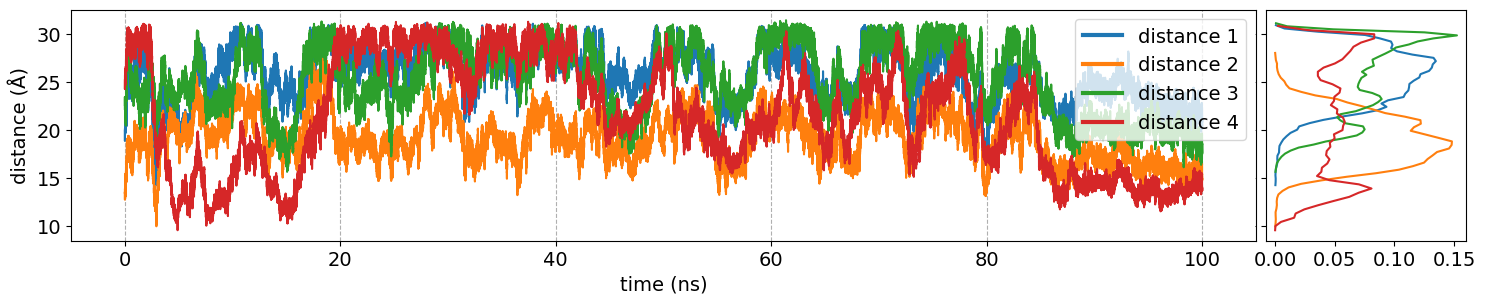

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(18, 3))
ax.plot(colv["time"]/1000,colv["d1"]*10,label="distance 1",c="tab:blue")
ax.plot(colv["time"]/1000,colv["d2"]*10,label="distance 2",c="tab:orange")
ax.plot(colv["time"]/1000,colv["d3"]*10,label="distance 3",c="tab:green")
ax.plot(colv["time"]/1000,colv["d4"]*10,label="distance 4",c="tab:red")
plt.xlabel('time (ns)',fontsize=14)
plt.ylabel('distance (Å)',fontsize=14)
plt.grid(axis='x', ls='--')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

leg=plt.legend(fontsize=14, loc="upper right")  
for line in leg.get_lines():
    line.set_linewidth(3.0)

divider = make_axes_locatable(ax)
ax_histy = divider.append_axes("right", 2, pad=0.1, sharey=ax)

y,x=np.histogram(colv["d1"]*10,bins=50,density=True)
ax_histy.plot((y+y)/2,x[:-1],'tab:blue')
y,x=np.histogram(colv["d2"]*10,bins=50,density=True)
ax_histy.plot((y+y)/2,x[:-1],'tab:orange')
y,x=np.histogram(colv["d3"]*10,bins=50,density=True)
ax_histy.plot((y+y)/2,x[:-1],'tab:green')
y,x=np.histogram(colv["d4"]*10,bins=50,density=True)
ax_histy.plot((y+y)/2,x[:-1],'tab:red')
ax_histy.set_xticks([0.00,0.05,0.10,0.15])
plt.xticks(fontsize=14)
ax_histy.set_yticks([10,15,20,25,30])
plt.yticks(fontsize=0)

plt.savefig(path_out+'dist_metad.svg', dpi=500, bbox_inches='tight')

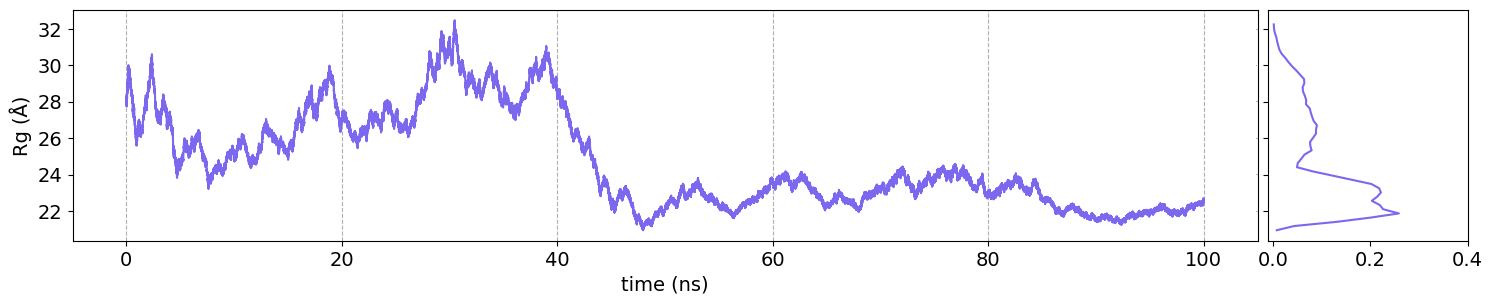

In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(18, 3))
plt.plot(colv["time"]/1000,colv["Rg"]*10,color='mediumslateblue')
plt.xlabel('time (ns)',fontsize=14)
plt.ylabel('Rg (Å)',fontsize=14)
plt.grid(axis='x', ls='--')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


divider = make_axes_locatable(ax)
ax_histy = divider.append_axes("right", 2, pad=0.1, sharey=ax)

y,x=np.histogram(colv["Rg"]*10,bins=50,density=True)
ax_histy.plot((y+y)/2,x[:-1],'mediumslateblue')
ax_histy.set_xticks([0,0.2,0.4])
plt.xticks(fontsize=14)
ax_histy.set_yticks([22,24,26,28,30,32])
plt.yticks(fontsize=0)

plt.savefig(path_out+'Rg_metad.svg', dpi=500, bbox_inches='tight')

In [44]:
u=MDAnalysis.Universe(path+"protein_renum.pdb",path+"whole_cen_mol_protein_100ns_vb.xtc")
ref=MDAnalysis.Universe(path+"protein_renum.pdb",path+"whole_cen_mol_protein_100ns_vb.xtc")

/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [45]:
Cterm = MDAnalysis.analysis.rms.RMSD(u, reference=None,ref_frame=0,
                                 select="resid 100 to 340 and not name H*")
Cterm.run()

In [46]:
Nterm_all = MDAnalysis.analysis.rms.RMSD(u, reference=None,ref_frame=0,
                                 select="resid 1 to 99 and not name H*")
Nterm_all.run()

In [47]:
pept = MDAnalysis.analysis.rms.RMSD(u, reference=None,ref_frame=0,
                                 select="resid 341 to 379 and not name H*")
pept.run()    

In [48]:
Cterm.rmsd.T.shape

/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:722: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


(3, 20001)

/home/mbernett/my_progs/miniconda3/envs/nb_articolo_rad/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:722: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


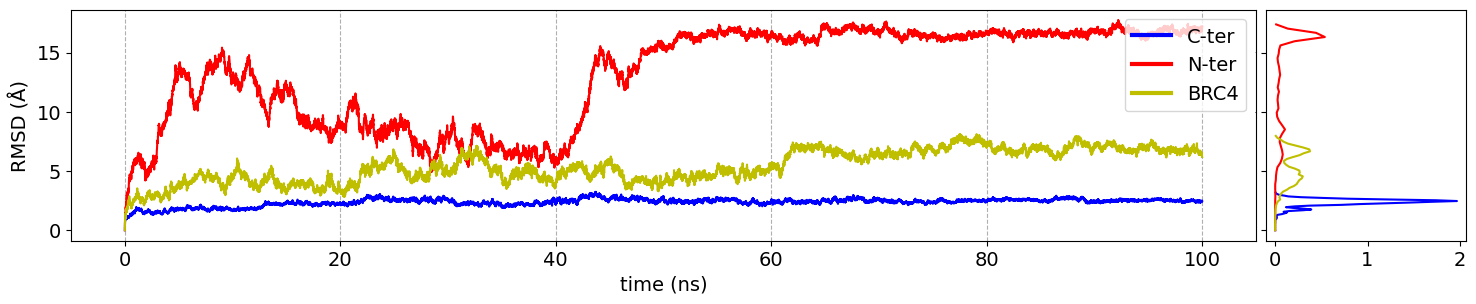

In [194]:
rmsdN_all = Nterm_all.rmsd.T
rmsdC = Cterm.rmsd.T
rmsdP = pept.rmsd.T
time = rmsdC[1]

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(18, 3))
ax.plot(time/1000, rmsdC[2], 'b-',  label="C-ter")
ax.plot(time/1000, rmsdN_all[2], 'r-',  label="N-ter")
ax.plot(time/1000, rmsdP[2], 'y-',  label="BRC4")
plt.xlabel('time (ns)',fontsize=14)
plt.ylabel('RMSD (Å)',fontsize=14)
plt.grid(axis='x', ls='--')
plt.xticks(fontsize=14)
plt.yticks([0.0,5.0,10,15],fontsize=14)

leg=plt.legend(fontsize=14, loc="upper right")  
for line in leg.get_lines():
    line.set_linewidth(3.0)

divider = make_axes_locatable(ax)
ax_histy = divider.append_axes("right", 2, pad=0.1, sharey=ax)

y,x=np.histogram(rmsdC[2],bins=50,density=True)
ax_histy.plot((y+y)/2,x[:-1],'b-')
y,x=np.histogram(rmsdN_all[2],bins=50,density=True)
ax_histy.plot((y+y)/2,x[:-1],'r-')
y,x=np.histogram(rmsdP[2],bins=50,density=True)
ax_histy.plot((y+y)/2,x[:-1],'y-')
ax_histy.set_xticks([0,1,2])
plt.xticks(fontsize=14)
ax_histy.set_yticks([0.0,5.0,10,15])
plt.yticks(fontsize=0)

plt.savefig(path_out+'rmsd_metad.svg', dpi=500, bbox_inches='tight')

### Reweighting

In [50]:
colv_rew=np.loadtxt(path+'colvar_metad_restr_bias_100ns')
colv_rew.shape

(20001, 9)

In [51]:
weights=np.exp((colv_rew[:,-1]-np.max(colv_rew[:,-1]))/2.5) # avoid numeric overflow
weights=weights/np.sum(weights) # normalize

In [52]:
histo=np.histogram(colv_rew[:,5],bins=51,range=(2.0,3.3),weights=weights) 
histo_nw=np.histogram(colv_rew[:,5],bins=51,range=(2.0,3.3)) 

/tmp/ipykernel_498599/3683275987.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot((histo_nw[1][:-1]+histo_nw[1][1:])/2,(-2.5*np.log(histo_nw[0])-np.min(-2.5*np.log(histo_nw[0])))/4.184,label='non weighted')
/tmp/ipykernel_498599/3683275987.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot((histo[1][:-1]+histo[1][1:])/2,(-2.5*np.log(histo[0])-np.min(-2.5*np.log(histo[0])))/4.184,label='rew. metad')


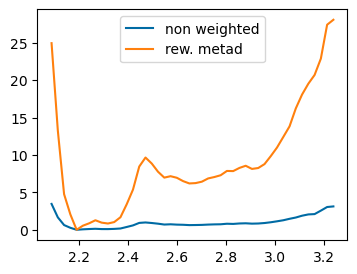

In [53]:
plt.plot((histo_nw[1][:-1]+histo_nw[1][1:])/2,(-2.5*np.log(histo_nw[0])-np.min(-2.5*np.log(histo_nw[0])))/4.184,label='non weighted')
plt.plot((histo[1][:-1]+histo[1][1:])/2,(-2.5*np.log(histo[0])-np.min(-2.5*np.log(histo[0])))/4.184,label='rew. metad')
plt.legend()
plt.show()

In [54]:
spectra_ob=np.loadtxt(path+'colvar_onebead_DRIVER_SolvStride1')
spectra_ob.shape

(20001, 55)

In [55]:
qs=exp_whole[selected_points,0]
exp=uf_exp_whole[selected_points]
scale_exp=np.exp(intercept)

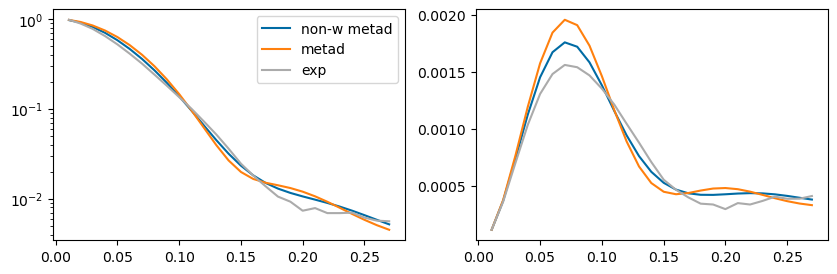

In [56]:
plt.figure(figsize=(10,3))
plt.tight_layout()
plt.subplot(1,2,1)
plt.plot(qs,np.average(spectra_ob[:,1:28],axis=0),label='non-w metad')
plt.plot(qs,np.average(spectra_ob[:,1:28],axis=0,weights=weights),label='metad')
plt.plot(qs,exp/scale_exp,label='exp')
plt.yscale('log')
plt.legend()
plt.subplot(1,2,2)
plt.plot(qs,np.average(spectra_ob[:,1:28]*qs**2,axis=0))
plt.plot(qs,np.average(spectra_ob[:,1:28]*qs**2,axis=0,weights=weights))
plt.plot(qs,exp/scale_exp*qs**2,label='exp')
plt.show()

In [57]:
# Maxent function:
def Gamma(l,metadb,observables,e,sigma=0.0):
    l = np.array(l)
    weight_all = metadb / 2.5 # metadb is the array of metadynamics bias associated with each frame (assigned using the total final bias)
    weight_all -= np.dot(observables,l) # lamba*s inside the exponential of the maxent formula
    shift_all = np.max(weight_all) # shift to be subtracted to avoid numerical overflow problems in the exponential
    weight_all = np.exp(weight_all - shift_all)

    weight_mt = metadb / 2.5 
    shift_mt = np.max(weight_mt) # shift to be subtracted to avoid numerical overflow problems in the exponential
    weight_mt = np.exp(weight_mt - shift_mt)

    f = np.log(np.sum(weight_all) / np.sum(weight_mt)) + shift_all - shift_mt + np.dot(l,e)
    der = e - np.dot(weight_all,observables) / np.sum(weight_all) # derivative with respect to l
    reg=sigma**2 # regularization term
    f+=0.5*np.sum(reg*l**2)
    der+=reg*l
    
    return(f,der)

def weights_noprop(l,metadb,observables,e):
    l = np.array(l)
    weight_all = metadb / 2.5
    obs_prop=observables - e
    #print(observables[0],obs_prop[0])

    weight_all -= np.dot(obs_prop,l) # lamba*s inside the exponential of the maxent formula
    shift_all = np.max(weight_all) # shift to be subtracted to avoid numerical overflow problems in the exponential
    weight_all = np.exp(weight_all - shift_all) 

    return weight_all/ np.sum(weight_all)

__Sanity check__ of the maxent function, using the __metad spectrum__ (instead of the exp.)  as target for maxent. This should return the original weights of the metad:

In [58]:
res = minimize(Gamma, np.zeros(qs.shape), method='BFGS',tol=1e-10,jac=True,
           args=(colv_rew[:,-1],spectra_ob[:,1:28],np.average(spectra_ob[:,1:28],axis=0,weights=weights),1e-10)) 

In [59]:
w_me = weights_noprop(res.x,colv_rew[:,-1],spectra_ob[:,1:28],np.average(spectra_ob[:,1:28],axis=0,weights=weights))

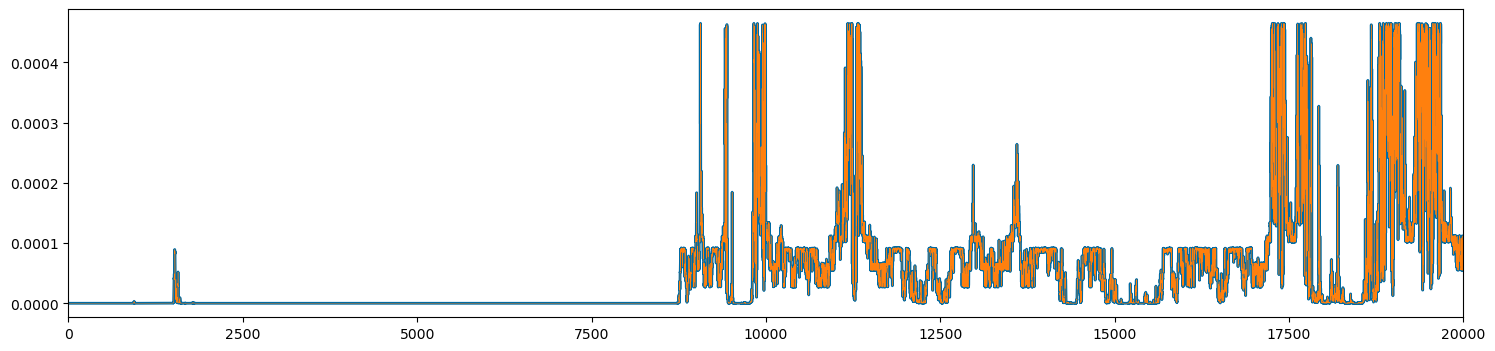

In [60]:
plt.figure(figsize=(18,4))
plt.plot(w_me,lw=2)
plt.plot(weights,lw=0.3)
plt.xlim(0,2e4)
plt.show()

In [61]:
sigmas=np.array([1e-10,1e-4,4e-4,5e-4,6e-4,8e-4,1e-3,2e-3,3e-3,4e-3,5e-3,1e-2,3e-2,5e-2,1e-1,1,1e1,1e2,1e3])
kishes={}
w_me={}
for i in range(len(sigmas)):
    res_i = minimize(Gamma, np.zeros(qs.shape), method='BFGS',tol=1e-10,jac=True,
                   args=(colv_rew[:,-1],spectra_ob[:,1:28],exp/scale_exp,sigmas[i]))
    w_me_i = weights_noprop(res_i.x,colv_rew[:,-1],spectra_ob[:,1:28],exp/scale_exp)
    w_me[sigmas[i]] = w_me_i # w_me.append(w_me_i)
    kish_i = 1 / np.sum(w_me_i**2)
    kishes[sigmas[i]] = kish_i # kishes.append(kish_i)
    print('Done with sigma=%s, kish size=%s'%(sigmas[i],kish_i))

Done with sigma=1e-10, kish size=1.0
Done with sigma=0.0001, kish size=2.826425604778795
Done with sigma=0.0004, kish size=18.190027967743717
Done with sigma=0.0005, kish size=41.735153778966264
Done with sigma=0.0006, kish size=77.73501481391799
Done with sigma=0.0008, kish size=168.05631675180777
Done with sigma=0.001, kish size=290.1423757094405
Done with sigma=0.002, kish size=1295.5695647730129
Done with sigma=0.003, kish size=2411.653993197652
Done with sigma=0.004, kish size=3181.475476825528
Done with sigma=0.005, kish size=3659.493989638231
Done with sigma=0.01, kish size=4611.992494060049
Done with sigma=0.03, kish size=7391.065538319239
Done with sigma=0.05, kish size=8571.734214940938
Done with sigma=0.1, kish size=7425.086083894069
Done with sigma=1.0, kish size=5032.778602713878
Done with sigma=10.0, kish size=4997.93465027221
Done with sigma=100.0, kish size=4997.586974054003
Done with sigma=1000.0, kish size=4997.583497369573


In [62]:
w_me.keys()

dict_keys([1e-10, 0.0001, 0.0004, 0.0005, 0.0006, 0.0008, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.03, 0.05, 0.1, 1.0, 10.0, 100.0, 1000.0])

In [63]:
kishe_sizes=np.array([kishes[a] for a in sigmas])

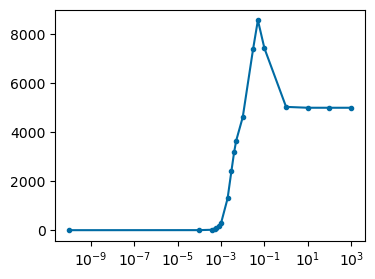

In [64]:
plt.plot(sigmas,kishe_sizes,'.-')
plt.xscale('log')
plt.show()

In [65]:
exp_error=exp_whole[selected_points,2]/scale_exp # normalize the residuals by exp. error

In [195]:
# find sigma that ~ minimizes overfitting (chi squared close to 1)
sigmas=np.array([5e-3,1e-2,2e-2,3e-2,3.5e-2,4e-2,5e-2])
for i in range(len(sigmas)):
    res_i = minimize(Gamma, np.zeros(qs.shape), method='BFGS',tol=1e-10,jac=True,
                   args=(colv_rew[:,-1],spectra_ob[:,1:28],exp/scale_exp,sigmas[i]))
    w_me_i = weights_noprop(res_i.x,colv_rew[:,-1],spectra_ob[:,1:28],exp/scale_exp)
    kish_i = 1 / np.sum(w_me_i**2)
    # error (bootstrap) on the spectra: MAXENT weights
    nb=10 # N blocks, applies to both weights and spectra arrays
    npt=27 # N points per observable: saxs spectra have 51 q points in my case
    weights_me=copy.deepcopy(w_me_i[:-1]) # remove last to allow division by 10..
    weights_me=weights_me.reshape((nb,-1)) # weights
    spectra=copy.deepcopy(spectra_ob[:-1,1:28]) # spectra
    spectra=spectra.reshape((nb,-1,npt))
    obs_j=[]
    for b in range(400):
        shuffle=np.random.choice(nb,size=nb) # re-sample by shuffling blocks
        resamp_w=weights_me[shuffle][:,:].reshape((-1)) # resampled weights
        resamp_s= spectra[shuffle][:,:,:].reshape((-1,npt)) # resampled spectra
        rew_s=(np.average(resamp_s,axis=0,weights=resamp_w/np.sum(resamp_w))) # reweighted spectrum
        # 
        obs_j.append(rew_s)
    obs_j=np.array(obs_j)
    err_maxent_i=np.std(obs_j,axis=0)
    # print 
    print('sigma=%s, kish size=%s, chi squared=%s'%(
        sigmas[i],kish_i,1/(qs.shape[0]-1)*np.sum(((np.average(spectra_ob[:,1:28],axis=0,weights=w_me_i)-(exp/scale_exp))/np.sqrt(exp_error**2+err_maxent_i**2))**2)))

sigma=0.005, kish size=3659.493989638231, chi squared=0.18174246400454033
sigma=0.01, kish size=4611.992494060049, chi squared=0.2371512979445486
sigma=0.02, kish size=5766.356147284109, chi squared=0.4081786336505693
sigma=0.03, kish size=7391.065538319239, chi squared=0.7806841943283183
sigma=0.035, kish size=8209.460665523537, chi squared=1.256814793996178
sigma=0.04, kish size=8779.595655367415, chi squared=1.8998477781960872
sigma=0.05, kish size=8571.734214940938, chi squared=4.0917031504991925


In [67]:
chosen_s=3e-2

In [68]:
kishes[chosen_s]

7391.065538319239

In [69]:
kishes[chosen_s],spectra_ob.shape[0],kishes[chosen_s]/spectra_ob.shape[0]

(7391.065538319239, 20001, 0.36953480017595314)

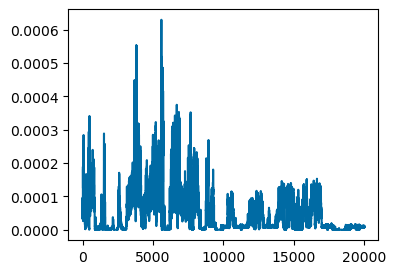

In [70]:
plt.plot(w_me[chosen_s])
plt.show()

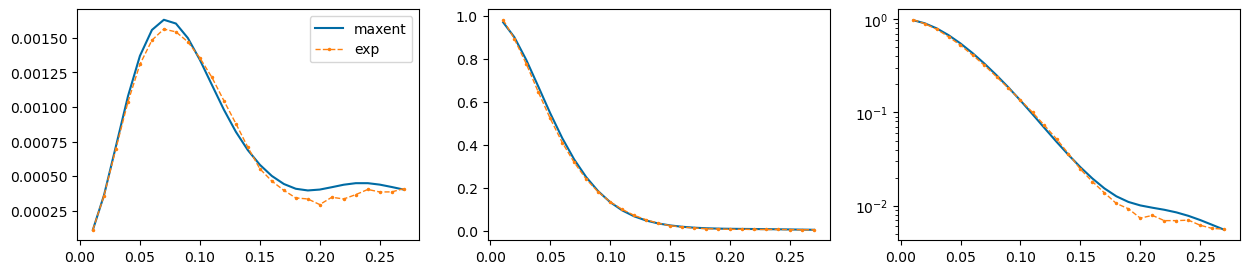

In [71]:
#plt.plot(qs,np.average(spectra_ob[:,1:20]*qs**2,axis=0,weights=weights),label='metad')
#plt.plot(qs,np.average(spectra_ob[:,1:20]*qs**2,axis=0,weights=weights_ww),label='metad+walls')
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(qs,np.average(spectra_ob[:,1:28]*qs**2,axis=0,weights=w_me[chosen_s]),label='maxent')
plt.plot(qs,exp/scale_exp*qs**2,'.--',lw=1,ms=3,label='exp')
plt.legend()

plt.subplot(1,3,2)
plt.plot(qs,np.average(spectra_ob[:,1:28],axis=0,weights=w_me[chosen_s]),label='maxent')
plt.plot(qs,(exp/scale_exp),'.--',lw=1,ms=3,label='exp')

plt.subplot(1,3,3)
plt.plot(qs,np.average(spectra_ob[:,1:28],axis=0,weights=w_me[chosen_s]),label='maxent')
plt.plot(qs,(exp/scale_exp),'.--',lw=1,ms=3,label='exp')
plt.yscale('log')
plt.show()

In [72]:
histo_me=np.histogram(colv_rew[:,5],bins=51,range=(2.0,3.3),weights=w_me[chosen_s])

/tmp/ipykernel_498599/2322869988.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot((histo[1][:-1]+histo[1][1:])/2,(-2.5*np.log(histo[0])-np.min(-2.5*np.log(histo[0])))/4.184,label='metad',c='C0',lw=2)
/tmp/ipykernel_498599/2322869988.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot((histo_me[1][:-1]+histo_me[1][1:])/2,(-2.5*np.log(histo_me[0])-np.min(-2.5*np.log(histo_me[0])))/4.184,label='maxent',c="C5",lw=2)


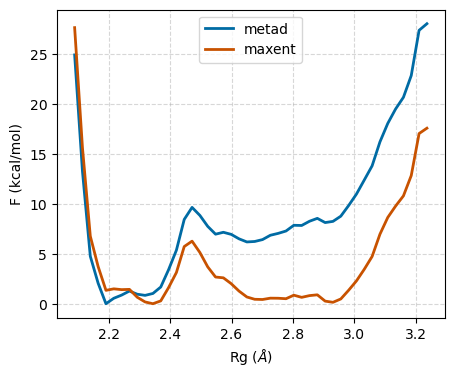

In [196]:
plt.figure(figsize=(5,4))
plt.style.use('tableau-colorblind10')
plt.grid(ls='--',alpha=0.5)
plt.plot((histo[1][:-1]+histo[1][1:])/2,(-2.5*np.log(histo[0])-np.min(-2.5*np.log(histo[0])))/4.184,label='metad',c='C0',lw=2)
plt.plot((histo_me[1][:-1]+histo_me[1][1:])/2,(-2.5*np.log(histo_me[0])-np.min(-2.5*np.log(histo_me[0])))/4.184,label='maxent',c="C5",lw=2)
plt.ylabel('F (kcal/mol)')
plt.xlabel('Rg ($\AA$)')
plt.legend()
plt.show()

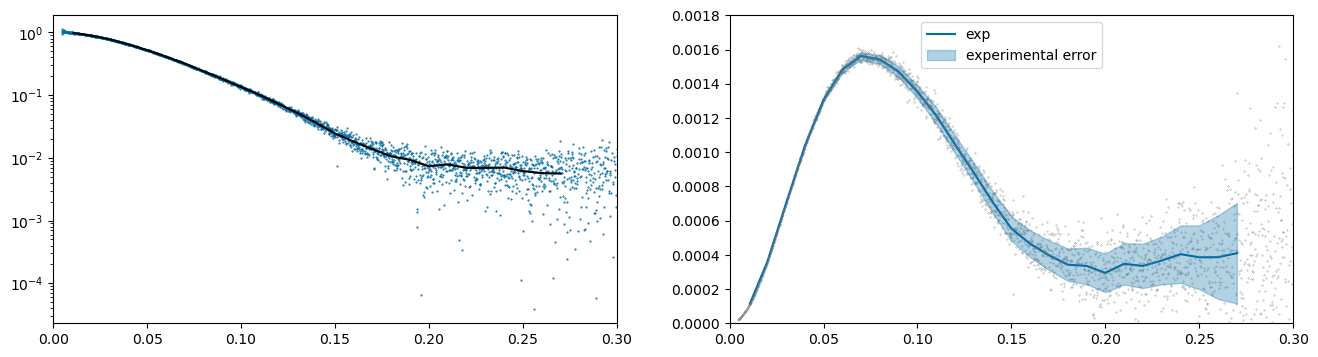

In [197]:
plt.figure(figsize=(16,4))
plt.tight_layout()

plt.subplot(1,2,1)
plt.plot(exp_whole[:,0],exp_whole[:,1]/scale_exp,'.',ms=1)
plt.plot(qs,exp/scale_exp,color='black')
plt.yscale('log')
plt.xlim(0,0.3)

plt.subplot(1,2,2)
plt.plot(qs,(exp/scale_exp)*qs**2,label='exp')

plt.fill_between(exp_whole[selected_points,0],
                 ((exp-exp_whole[selected_points,2])/scale_exp)*exp_whole[selected_points,0]**2,
                 ((exp+exp_whole[selected_points,2])/scale_exp)*exp_whole[selected_points,0]**2,
                 color='C0',label='experimental error',zorder=10,alpha=0.3)
plt.plot(exp_whole[:,0],(exp_whole[:,1]/scale_exp)*exp_whole[:,0]**2,'.',ms=0.5,color='grey')
plt.ylim(0,1.8e-3)
plt.xlim(0,0.3)
plt.legend()

plt.show()

In [198]:
# error (bootstrap) on the spectra: MAXENT weights
# error
nb=10 # N blocks, applies to both weights and spectra arrays
npt=27 # N points per observable: saxs spectra have 51 q points in my case
weights_me=copy.deepcopy(w_me[chosen_s][:-1]) # remove last to allow division by 10..
weights_me=weights_me.reshape((nb,-1)) # weights
spectra=copy.deepcopy(spectra_ob[:-1,1:28]) # spectra
spectra=spectra.reshape((nb,-1,npt))
obs_j=[]
for b in range(400):
    shuffle=np.random.choice(nb,size=nb) # re-sample by shuffling blocks
    resamp_w=weights_me[shuffle][:,:].reshape((-1)) # resampled weights
    #
    resamp_s= spectra[shuffle][:,:,:].reshape((-1,npt)) # resampled spectra
    rew_s=(np.average(resamp_s,axis=0,weights=resamp_w/np.sum(resamp_w))) # reweighted spectrum
    # 
    obs_j.append(rew_s)
obs_j=np.array(obs_j)
err_maxent=np.std(obs_j,axis=0)

In [199]:
# error (bootstrap) on the spectra: METAD weights
# error
nb=10 # N blocks, applies to both weights and spectra arrays
npt=27 # N points per observable: saxs spectra have 51 q points in my case
weights_metad=copy.deepcopy(weights[:-1]) # remove last to allow division by 10..
weights_metad=weights_metad.reshape((nb,-1)) # weights
spectra=copy.deepcopy(spectra_ob[:-1,1:28]) # spectra
spectra=spectra.reshape((nb,-1,npt))
obs_j=[]
for b in range(400):
    shuffle=np.random.choice(nb,size=nb) # re-sample by shuffling blocks
    resamp_w=weights_metad[shuffle][:,:].reshape((-1)) # resampled weights
    #
    resamp_s= spectra[shuffle][:,:,:].reshape((-1,npt)) # resampled spectra
    rew_s=(np.average(resamp_s,axis=0,weights=resamp_w/np.sum(resamp_w))) # reweighted spectrum
    # 
    obs_j.append(rew_s)
obs_j=np.array(obs_j)
err_metad=np.std(obs_j,axis=0)

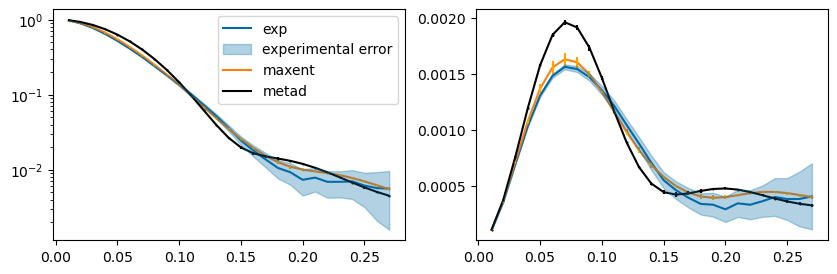

In [77]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(qs,(exp/scale_exp),label='exp')
plt.fill_between(exp_whole[selected_points,0],
                 ((exp-exp_whole[selected_points,2])/scale_exp),
                 ((exp+exp_whole[selected_points,2])/scale_exp),
                 color='C0',label='experimental error',zorder=10,alpha=0.3)
plt.plot(qs,np.average(spectra_ob[:,1:28],axis=0,weights=w_me[chosen_s]),label='maxent')
plt.errorbar(qs,np.average(spectra_ob[:,1:28],axis=0,weights=w_me[chosen_s]),yerr=err_maxent,fmt='.',ms=1,color='orange')
plt.plot(qs,np.average(spectra_ob[:,1:28],axis=0,weights=weights),label='metad',color='black')
plt.errorbar(qs,np.average(spectra_ob[:,1:28],axis=0,weights=weights),yerr=err_metad,fmt='.',ms=1,color='black')
plt.legend()
plt.yscale('log')
plt.legend()

plt.subplot(1,2,2)
plt.plot(qs,(exp/scale_exp)*qs**2,label='exp')
plt.plot(qs,np.average(spectra_ob[:,1:28]*qs**2,axis=0,weights=w_me[chosen_s]),label='maxent')
plt.errorbar(qs,np.average(spectra_ob[:,1:28]*qs**2,axis=0,weights=w_me[chosen_s]),yerr=err_maxent*qs**2,fmt='.',ms=1,color='orange')
plt.plot(qs,np.average(spectra_ob[:,1:28]*qs**2,axis=0,weights=weights),label='metad',color='black')
plt.errorbar(qs,np.average(spectra_ob[:,1:28]*qs**2,axis=0,weights=weights),yerr=err_metad*qs**2,fmt='.',ms=1,color='black')
plt.fill_between(exp_whole[selected_points,0],
                 ((exp-exp_whole[selected_points,2])/scale_exp)*exp_whole[selected_points,0]**2,
                 ((exp+exp_whole[selected_points,2])/scale_exp)*exp_whole[selected_points,0]**2,
                 color='C0',label='experimental error',zorder=10,alpha=0.3)


plt.show()

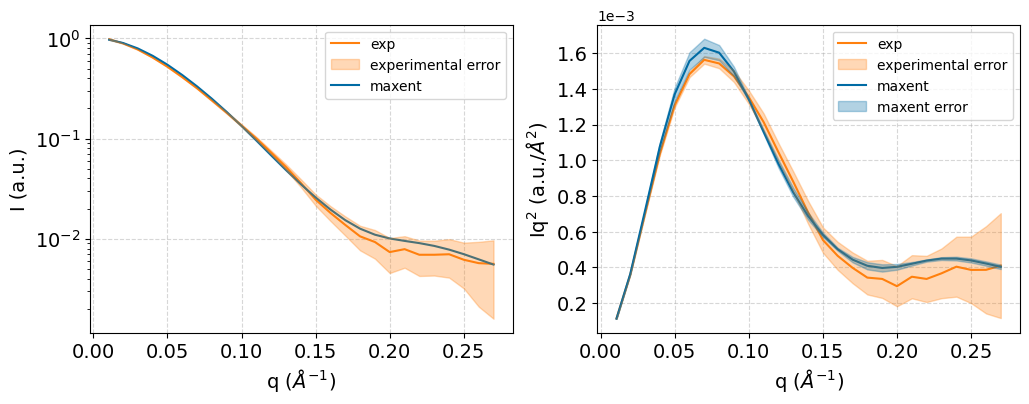

In [200]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.ylabel('Iq$^2$ (a.u./$\AA^2$)',fontsize=14)
plt.xlabel('q ($\AA^{-1}$)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(ls='--',alpha=0.5)
plt.plot(qs,(exp/scale_exp)*qs**2,label='exp',color='C1')
plt.fill_between(exp_whole[selected_points,0],
                 ((exp-exp_whole[selected_points,2])/scale_exp)*exp_whole[selected_points,0]**2,
                 ((exp+exp_whole[selected_points,2])/scale_exp)*exp_whole[selected_points,0]**2,
                 color='C1',label='experimental error',zorder=10,alpha=0.3)
plt.plot(qs,np.average(spectra_ob[:,1:28]*qs**2,axis=0,weights=w_me[chosen_s]),label='maxent',color='C0')
plt.fill_between(exp_whole[selected_points,0],
                 (np.average(spectra_ob[:,1:28],axis=0,weights=w_me[chosen_s])-err_maxent)*exp_whole[selected_points,0]**2,
                 (np.average(spectra_ob[:,1:28],axis=0,weights=w_me[chosen_s])+err_maxent)*exp_whole[selected_points,0]**2,
                 color='C0',label='maxent error',zorder=10,alpha=0.3)
plt.legend()

plt.subplot(1,2,1)
plt.grid(ls='--',alpha=0.5)
plt.ylabel('I (a.u.)',fontsize=14)
plt.xlabel('q ($\AA^{-1}$)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(qs,(exp/scale_exp),label='exp',color='C1')
plt.fill_between(exp_whole[selected_points,0],
                 ((exp-exp_whole[selected_points,2])/scale_exp),
                 ((exp+exp_whole[selected_points,2])/scale_exp),
                 color='C1',label='experimental error',zorder=10,alpha=0.3)
plt.plot(qs,np.average(spectra_ob[:,1:28],axis=0,weights=w_me[chosen_s]),label='maxent',color='C0')
plt.legend()
plt.yscale('log')
plt.legend()
plt.show()

In [201]:
# chi squared, computed-exp: CONSISTENT WITH PRIMUS
1/(qs.shape[0]-1)*np.sum(((np.average(spectra_ob[:,1:28],axis=0,weights=w_me[chosen_s])-(exp/scale_exp))/np.sqrt(exp_error**2+err_maxent**2))**2)

0.8797552646573353

In [202]:
# error (bootstrap) on the spectra: MAXENT weights
# error on the residuals
nb=10 # N blocks, applies to both weights and spectra arrays
npt=27 # N points per observable: saxs spectra have 51 q points in my case
weights_me=copy.deepcopy(w_me[chosen_s][:-1]) # remove last to allow division by 10..
weights_me=weights_me.reshape((nb,-1)) # weights
spectra=copy.deepcopy(spectra_ob[:-1,1:28]) # spectra
spectra=spectra.reshape((nb,-1,npt))
obs_j=[]
for b in range(400):
    shuffle=np.random.choice(nb,size=nb) # re-sample by shuffling blocks
    resamp_w=weights_me[shuffle][:,:].reshape((-1)) # resampled weights
    #
    resamp_s= spectra[shuffle][:,:,:].reshape((-1,npt)) # resampled spectra
    rew_s=(np.average(resamp_s,axis=0,weights=resamp_w/np.sum(resamp_w))) # reweighted spectrum
    # 
    residuals_i=(((exp/scale_exp)-rew_s)/np.sqrt(exp_error**2+err_maxent**2)) # (((exp/scale_exp)-rew_s)/exp_error) 
    obs_j.append(residuals_i)
obs_j=np.array(obs_j)
err_maxent_residuals=np.std(obs_j,axis=0)

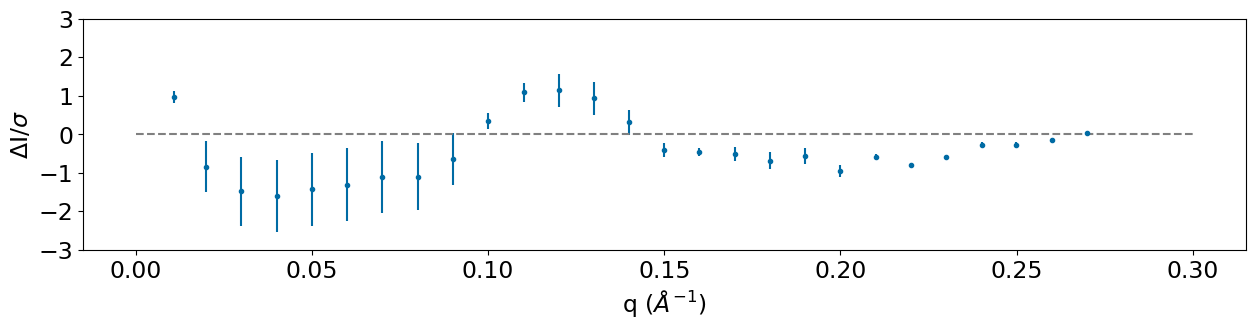

In [81]:
# CONSISTENT with primus + error (via bootstrap) on the calculated spectrum 
plt.figure(figsize=(15,3))
plt.style.use('tableau-colorblind10')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
exp_error=exp_whole[selected_points,2]/scale_exp # normalize the residuals by exp. error (!!DOUBLE CHECK ERROR PROPAGATION!!)
#plt.plot(qs,((exp/scale_exp)-np.average(spectra_ob[:,1:28],axis=0,weights=w_me[chosen_s]))/np.sqrt(exp_error**2+err_maxent**2),'o')
plt.errorbar(qs,((exp/scale_exp)-np.average(spectra_ob[:,1:28],axis=0,weights=w_me[chosen_s]))/np.sqrt(exp_error**2+err_maxent**2),yerr=err_maxent_residuals,fmt='.',label='rew. maxent')
plt.hlines(0,0,0.3,ls='--',color='grey')
plt.ylabel('$\Delta$I/$\sigma$',fontsize=17)
plt.xlabel('q ($\AA^{-1}$)',fontsize=17)
plt.ylim(-3,3)
plt.savefig(path_out+'residuals.svg',dpi=300,bbox_inches='tight')
plt.show()

In [203]:
# error (bootstrap) on the spectra: METAD weights
# error on the residuals
nb=10 # N blocks, applies to both weights and spectra arrays
npt=27 # N points per observable: saxs spectra have 51 q points in my case
weights_metad=copy.deepcopy(weights[:-1]) # remove last to allow division by 10..
weights_metad=weights_metad.reshape((nb,-1)) # weights
spectra=copy.deepcopy(spectra_ob[:-1,1:28]) # spectra
spectra=spectra.reshape((nb,-1,npt))
obs_j=[]
for b in range(400):
    shuffle=np.random.choice(nb,size=nb) # re-sample by shuffling blocks
    resamp_w=weights_metad[shuffle][:,:].reshape((-1)) # resampled weights
    #
    resamp_s= spectra[shuffle][:,:,:].reshape((-1,npt)) # resampled spectra
    rew_s=(np.average(resamp_s,axis=0,weights=resamp_w/np.sum(resamp_w))) # reweighted spectrum
    # 
    residuals_i=(((exp/scale_exp)-rew_s)/np.sqrt(exp_error**2+err_metad**2)) # ((rew_s-(exp/scale_exp))/exp_error)
    obs_j.append(residuals_i)
obs_j=np.array(obs_j)
err_metad_residuals=np.std(obs_j,axis=0)

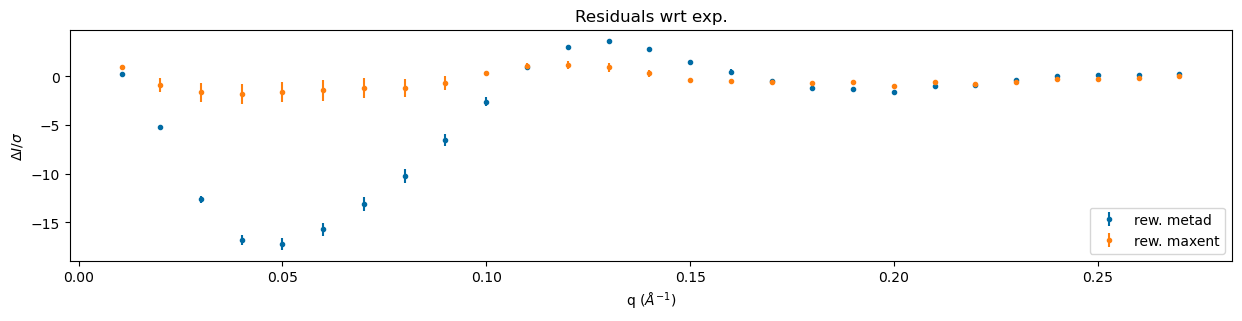

In [204]:
# normalized difference, with statistical error
exp_error=exp_whole[selected_points,2]/scale_exp
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(15,3))
plt.errorbar(qs,((exp/scale_exp)-np.average(spectra_ob[:,1:28],axis=0,weights=weights))/np.sqrt(exp_error**2+err_metad**2),yerr=err_metad_residuals,fmt='.',label='rew. metad')
plt.errorbar(qs,((exp/scale_exp)-np.average(spectra_ob[:,1:28],axis=0,weights=w_me[chosen_s]))/np.sqrt(exp_error**2+err_maxent**2),yerr=err_maxent_residuals,fmt='.',label='rew. maxent')
plt.ylabel('${\Delta}I/{\sigma}$')
plt.xlabel('q ($\AA^{-1}$)')
plt.title('Residuals wrt exp.')
plt.legend()
plt.savefig(path_out+'residuals_si.svg',dpi=300,bbox_inches='tight')
plt.show()

### Compute populations

/tmp/ipykernel_498599/2311887037.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot((histo[1][:-1]+histo[1][1:])/2,(-2.5*np.log(histo[0])-np.min(-2.5*np.log(histo[0])))/4.184,label='rew. metad')
/tmp/ipykernel_498599/2311887037.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot((histo_me[1][:-1]+histo_me[1][1:])/2,(-2.5*np.log(histo_me[0])-np.min(-2.5*np.log(histo_me[0])))/4.184,label='rew. maxent')


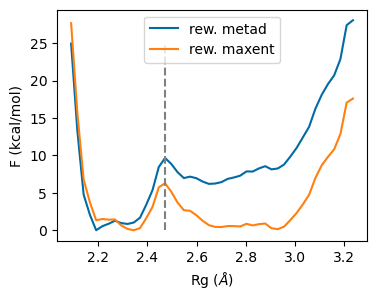

In [84]:
plt.plot((histo[1][:-1]+histo[1][1:])/2,(-2.5*np.log(histo[0])-np.min(-2.5*np.log(histo[0])))/4.184,label='rew. metad')
plt.plot((histo_me[1][:-1]+histo_me[1][1:])/2,(-2.5*np.log(histo_me[0])-np.min(-2.5*np.log(histo_me[0])))/4.184,label='rew. maxent')
plt.vlines(2.47,0,25,ls='--',color='grey')
plt.ylabel('F (kcal/mol)')
plt.xlabel('Rg ($\AA$)')
plt.legend()
plt.show()

In [85]:
# extended populations (Rg>2.47)
# maxent, metad
np.sum(w_me[chosen_s][np.where(colv_rew[:,5]>2.47)]),np.sum(weights[np.where(colv_rew[:,5]>2.47)])

(0.6468884688385294, 6.345588513184506e-05)

In [86]:
# compact populations (Rg<2.47)
# maxent, metad
np.sum(w_me[chosen_s][np.where(colv_rew[:,5]<2.47)]),np.sum(weights[np.where(colv_rew[:,5]<2.47)])

(0.35311153116147076, 0.9999365441148682)

## Contacts

In [87]:
traj=mdt.load(path+'whole_cen_mol_protein_100ns_vb.xtc',top=path+'last_frame_replicate1_protein.pdb')

In [88]:
traj

<mdtraj.Trajectory with 20001 frames, 5829 atoms, 379 residues, and unitcells at 0x7f8e07f53df0>

In [89]:
table, bonds = traj.top.to_dataframe()

In [90]:
chainA_idx=np.where(table['chainID'].to_numpy()==0)[0]

Nter: 24 to 84 counting from 1, thus 23 to 83 i.e. [23:84]  
Brc4: 340 to 378 i.e. [340:379]

In [91]:
ctcs=mdt.compute_contacts(traj,contacts=[[23, 339], [0, 378]],scheme='closest-heavy')

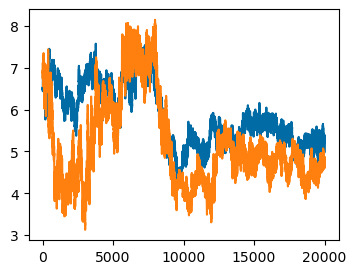

In [92]:
plt.plot(ctcs[0][:,0])
plt.plot(ctcs[0][:,1])

In [93]:
brc4_grp=np.array(list(itertools.product(np.arange(340,379,1),np.arange(23,84,1))))
brc4_grp.shape

(2379, 2)

In [94]:
brc4_grp_allN=np.array(list(itertools.product(np.arange(340,379,1),np.arange(0,84,1))))
brc4_grp_allN.shape

(3276, 2)

In [95]:
brc4_ctc=mdt.compute_contacts(traj,contacts=brc4_grp,scheme='closest-heavy')

In [96]:
start=datetime.datetime.now()

brc4_ctc_allN=mdt.compute_contacts(traj,contacts=brc4_grp_allN,scheme='closest-heavy')

end=datetime.datetime.now()
tdelta=end-start
print("total seconds:",tdelta.total_seconds())

total seconds: 363.674327


In [97]:
np.unique(brc4_ctc[1][:,0]).shape,np.unique(brc4_ctc[1][:,1]).shape

((39,), (61,))

In [98]:
brc4_ctc_filt=1*(brc4_ctc[0]<0.5)

In [99]:
brc4_ctc_allN_filt=1*(brc4_ctc_allN[0]<0.5)

In [100]:
brc4_ctc_filt_resh=brc4_ctc_filt.reshape(brc4_ctc_filt.shape[0],-1,61)

In [101]:
brc4_ctc_allN_filt_resh=brc4_ctc_allN_filt.reshape(brc4_ctc_allN_filt.shape[0],-1,84)

In [102]:
nter_grp=np.array(list(itertools.product(np.arange(23,84,1),np.arange(340,379,1))))

In [103]:
nter_grp_allN=np.array(list(itertools.product(np.arange(0,84,1),np.arange(340,379,1))))

In [104]:
start=datetime.datetime.now()

nter_ctc=mdt.compute_contacts(traj,contacts=nter_grp,scheme='closest-heavy')

end=datetime.datetime.now()
tdelta=end-start
print("total seconds:",tdelta.total_seconds())

total seconds: 266.887812


In [105]:
nter_ctc_filt=1*(nter_ctc[0]<0.5)

In [106]:
nter_ctc_filt_resh=nter_ctc_filt.reshape(nter_ctc_filt.shape[0],-1,39)

In [107]:
chainA_idx=np.where(table['chainID'].to_numpy()==0)[0]
chainB_idx=np.where(table['chainID'].to_numpy()==1)[0]

In [108]:
# residue.index counts from 0, residue.resSeq counts as the pdb (e.g. from 1), compute_contacts considers residues 0-indexed
nter_residues=[a.residue for a in traj.top.atoms if a.index in chainA_idx if a.name=='CA' if a.residue.resSeq in np.linspace(24,84,61,dtype=int)] # resids 24 to 84
brc4_residues=[a.residue for a in traj.top.atoms if a.index in chainB_idx if a.name=='CA' if a.residue.resSeq in np.linspace(1,39,40,dtype=int)] 

In [109]:
# residue.index counts from 0, residue.resSeq counts as the pdb (e.g. from 1), compute_contacts considers residues 0-indexed
nter_allN_residues=[a.residue for a in traj.top.atoms if a.index in chainA_idx if a.name=='CA' if a.residue.resSeq in np.linspace(0,84,85,dtype=int)]
cter_allN_residues=[a.residue for a in traj.top.atoms if a.index in chainA_idx if a.name=='CA' if a.residue.resSeq in np.linspace(84,340,256,dtype=int)]

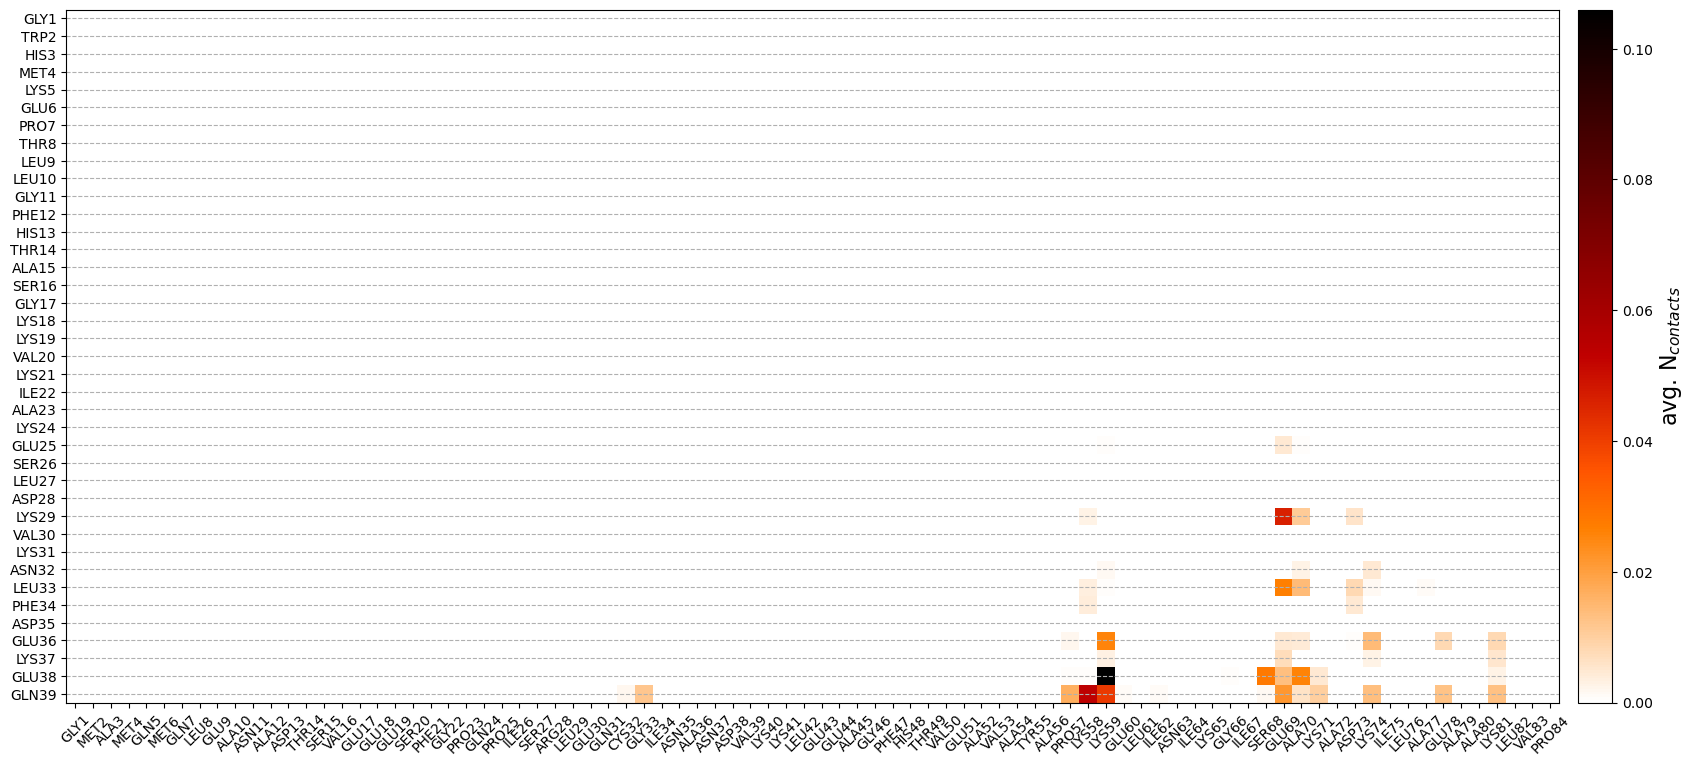

In [205]:
from matplotlib import colormaps
plt.figure(figsize=(24,9))
cmap = colormaps['gist_heat_r']
plt.imshow(np.average(brc4_ctc_allN_filt_resh,axis=0,weights=w_me[chosen_s]),cmap)
plt.colorbar(orientation="vertical",pad=0.01).ax.set_ylabel('avg. N$_{contacts}$', fontsize=16)
plt.yticks(np.linspace(0,38,39),brc4_residues)
plt.xticks(np.linspace(0,83,84),nter_allN_residues,rotation=45)
plt.grid(axis='y',ls='--')
plt.savefig(path_out+'contacts_matrix_new_heat.png',dpi=300,bbox_inches='tight')

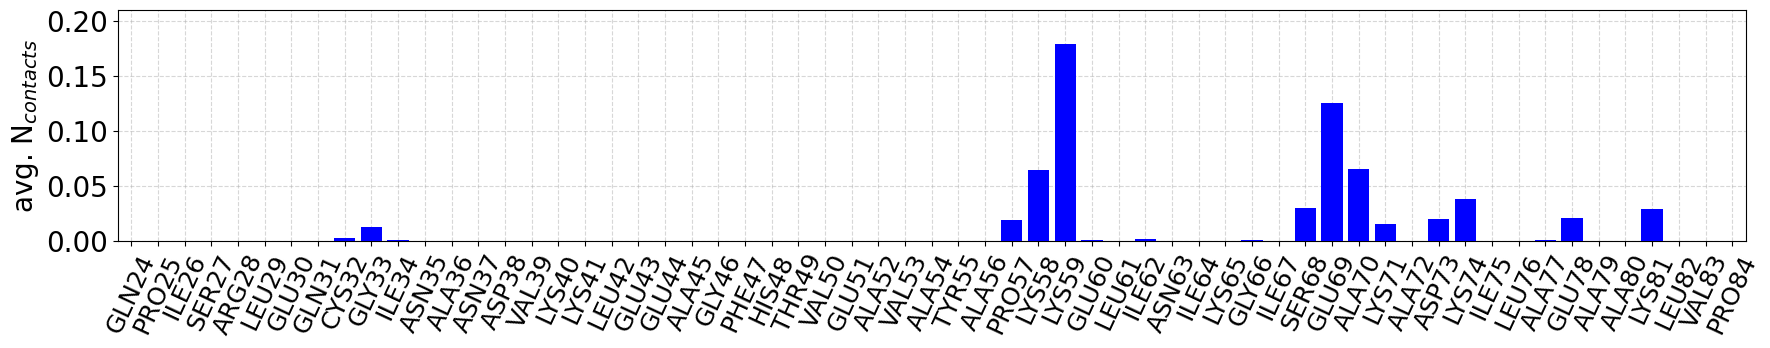

In [111]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(21,3))
plt.bar(np.linspace(0,60,61),np.average(np.sum(nter_ctc_filt_resh,axis=2),axis=0,weights=w_me[chosen_s]),width=0.8,zorder=10,color='blue')
plt.xticks(np.linspace(0,60,61),nter_residues,rotation=65,fontsize=18)
plt.xlim(-0.5,60.5)
plt.ylim(0,0.21)
plt.ylabel('avg. N$_{contacts}$',fontsize=20)
plt.yticks(fontsize=20)
plt.grid(ls='--',alpha=0.5)
plt.savefig(path_out+'contacts_nter.svg',dpi=300,bbox_inches='tight')
plt.show()

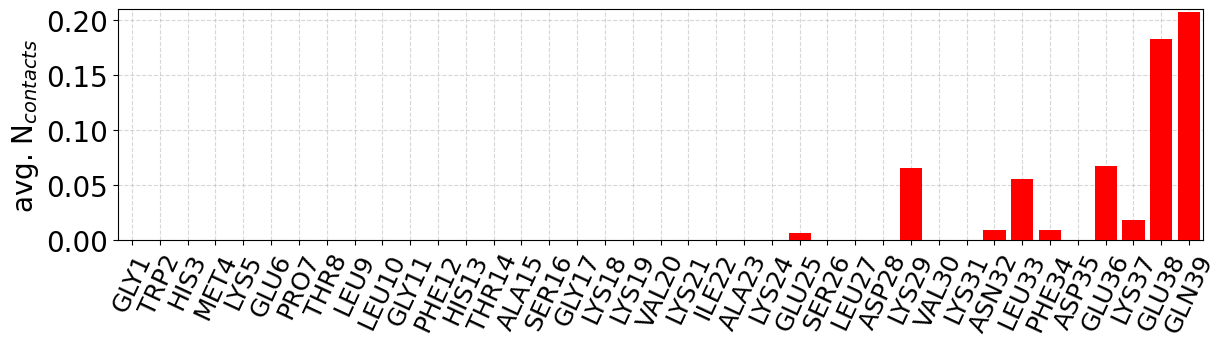

In [112]:
plt.style.use('tableau-colorblind10')
plt.figure(figsize=(14,3))
plt.bar(np.linspace(0,38,39),np.average(np.sum(brc4_ctc_filt_resh,axis=2),axis=0,weights=w_me[chosen_s]),width=0.8,zorder=10,color='red')
plt.xticks(np.linspace(0,38,39),brc4_residues,rotation=65,fontsize=18)
plt.yticks(fontsize=20)
plt.xlim(-0.5,38.5)
plt.ylim(0,0.21)
plt.ylabel('avg. N$_{contacts}$',fontsize=20)
plt.grid(ls='--',alpha=0.5)
plt.savefig(path_out+'contacts_brc4.svg',dpi=300,bbox_inches='tight')
plt.show()

## Clustering

### PCA

In [113]:
chainB_ca_idx=np.array([a.index for a in traj.top.atoms if a.index in chainB_idx if a.name=='CA'])
chainB_ca_idx.shape

(39,)

In [114]:
# N-ter CA
nter_ca_idx=np.array([a.index for a in traj.top.atoms if a.index in chainA_idx if a.name=='CA' if a.residue.resSeq in np.linspace(1,84,84,dtype=int)]) # resids 1 to 84
loop_ca_idx=np.array([a.index for a in traj.top.atoms if a.index in chainA_idx if a.name=='CA' if a.residue.resSeq in np.linspace(85,99,15,dtype=int)]) # resids 85 to 99
cter_ca_idx=np.array([a.index for a in traj.top.atoms if a.index in chainA_idx if a.name=='CA' if a.residue.resSeq in np.linspace(100,340,241,dtype=int)]) # resids 100 to 340

In [206]:
chainB_ca_idx=chainB_ca_idx[:] #whole selection

In [207]:
# alignment on C-ter CA
traj.superpose(traj, frame=0, atom_indices=cter_ca_idx)

<mdtraj.Trajectory with 20001 frames, 5829 atoms, 379 residues, and unitcells at 0x7f8e07f53df0>

In [208]:
chain_A=np.array([a.index for a in traj.top.atoms if a.index in chainA_idx if a.name=='CA' if a.residue.resSeq in np.linspace(1,340,340,dtype=int)])

In [209]:
whole_sel=np.concatenate((chain_A,chainB_ca_idx))
chain_A.shape,chainB_ca_idx.shape,whole_sel.shape

((340,), (39,), (379,))

In [119]:
cleaned_coords=traj.xyz[:,whole_sel,:]
cleaned_coords.shape

(20001, 379, 3)

In [120]:
pca = PCA()

In [121]:
traj_reshaped=cleaned_coords.reshape(traj.n_frames, -1)
traj_reshaped.shape

(20001, 1137)

In [122]:
pca_xyz = pca.fit_transform(traj_reshaped)
pca_xyz.shape

(20001, 1137)

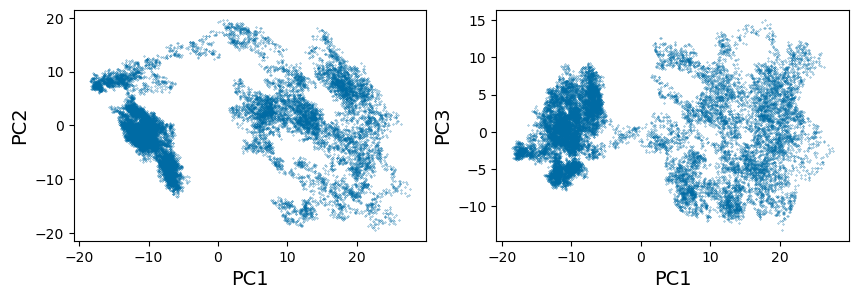

In [123]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(pca_xyz[:,0],pca_xyz[:,1],'.',ms=0.5)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
plt.subplot(1,2,2)
plt.plot(pca_xyz[:,0],pca_xyz[:,2],'.',ms=0.5)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC3',fontsize=14)
plt.show()

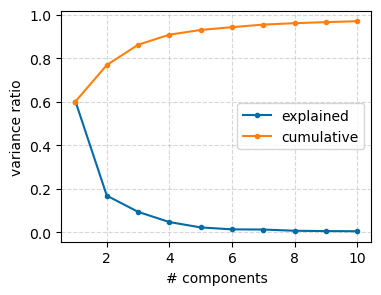

In [124]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.linspace(1,10,10),pca.explained_variance_ratio_[0:10],'.-',label='explained')
plt.plot(np.linspace(1,10,10),cumulative_variance_ratio[0:10],'.-',label='cumulative')
plt.grid(ls='--',alpha=0.5)
plt.xlabel('# components')
plt.ylabel('variance ratio')
plt.legend()

In [125]:
pca_5=pca_xyz[:,:5]

In [210]:
mat_pca=sp.spatial.distance_matrix(pca_5,pca_5)

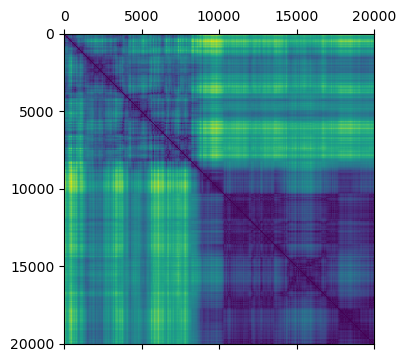

In [127]:
plt.matshow(mat_pca)

### low rg matrix

In [128]:
frame_rg_b_int=np.where(colv_rew[:,5]<2.47)[0]

In [129]:
pca_5.shape

(20001, 5)

In [130]:
points_rg_b=pca_5[frame_rg_b_int]
points_rg_b.shape

(11871, 5)

In [131]:
mat_pca_rg_b=sp.spatial.distance_matrix(points_rg_b,points_rg_b)

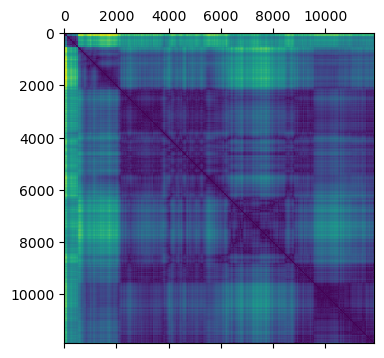

In [132]:
plt.matshow(mat_pca_rg_b)

### high rg matrix

In [133]:
frame_rg_a_int=np.where(colv_rew[:,5]>2.47)[0]

In [134]:
points_rg_a=pca_5[frame_rg_a_int]
points_rg_a.shape

(8130, 5)

In [135]:
mat_pca_rg_a=sp.spatial.distance_matrix(points_rg_a,points_rg_a)

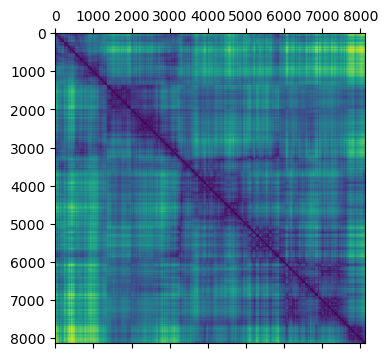

In [136]:
plt.matshow(mat_pca_rg_a)

### QT rg b

In [137]:
weights_rg_b=w_me[chosen_s][frame_rg_b_int]

In [138]:
start=datetime.datetime.now()

cl_qt_cf3_rg_b=clustering.qt(np.array(mat_pca_rg_b,dtype='float32'),weights=weights_rg_b,cutoff=3)

end=datetime.datetime.now()
tdelta=end-start
print("total seconds:",tdelta.total_seconds())

total seconds: 34333.549443


In [139]:
pickle.dump(cl_qt_cf3_rg_b,open(path_out+'clQT_allfr_cf3_s0-03_rg_b.dat', "wb"))

In [140]:
cl_qt_cf3_rg_b=pickle.load(open(path_out+"clQT_allfr_cf3_s0-03_rg_b.dat", "rb"))

In [141]:
np.sum(cl_qt_cf3_rg_b.weights)

0.35311153116147076

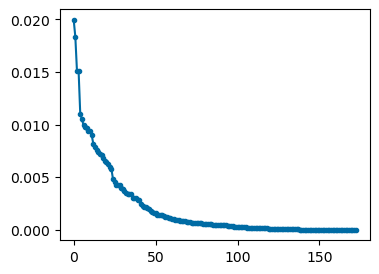

In [142]:
plt.plot(cl_qt_cf3_rg_b.weights,'.-')
plt.show()

In [143]:
cl_qt_cf3_outb={}
for i in range(len(cl_qt_cf3_rg_b.clusters)):
    cl_qt_cf3_outb[i,'lbl']=np.array(cl_qt_cf3_rg_b.clusters[i])
    cl_qt_cf3_outb[i,'size']=len(cl_qt_cf3_rg_b.clusters[i])
    cl_qt_cf3_outb[i,'weight']=cl_qt_cf3_rg_b.weights[i]

In [144]:
sizes_b=[]
weights_b=[]
for i in range(len(cl_qt_cf3_rg_b.clusters)):
    sizes_b.append(cl_qt_cf3_outb[i,'size'])
    weights_b.append(cl_qt_cf3_outb[i,'weight'])
sizes_b=np.array(sizes_b)
weights_b=np.array(weights_b)

In [145]:
# find centroids, taken from: https://mdtraj.org/1.9.3/examples/centroids.html
# ADAPTED with weights (mbernett)
centroids=[]
for i in range(50):
    cl=cl_qt_cf3_outb[i,'lbl'] # get cluster elements
    dists_i=mat_pca_rg_b[cl][:,cl] # subselect (from the full original mat) distance matrix for the cluster elements
    #
    beta = 1
    index = np.argmax(np.sum(np.exp(-beta*dists_i / dists_i.std())*weights_rg_b[cl],axis=1)) # index of centroid in the subselected mat
    centroids.append(cl[index]) # index of centroid in the original array
centroids_b=np.array(centroids)

In [146]:
# weighted average Rg of the clusters
cl_rgs_mb=[]
for i in range(50):
    cl_rgs_mb.append(np.average(colv_rew[frame_rg_b_int,5][cl_qt_cf3_outb[i,'lbl']],weights=weights_rg_b[cl_qt_cf3_outb[i,'lbl']])) # (should be) fixed

In [147]:
for i in range(10):
    print('cluster ID:',i,\
          'N_structures:',cl_qt_cf3_outb[i,'size'],\
          'Cluster_weight:',cl_qt_cf3_outb[i,'weight'],\
          'Weighted_Rg_of_cluster:',np.average(colv_rew[frame_rg_b_int,5][cl_qt_cf3_outb[i,'lbl']],weights=weights_rg_b[cl_qt_cf3_outb[i,'lbl']]))

cluster ID: 0 N_structures: 268 Cluster_weight: 0.019960123484015522 Weighted_Rg_of_cluster: 2.34797601191706
cluster ID: 1 N_structures: 264 Cluster_weight: 0.018337833713272883 Weighted_Rg_of_cluster: 2.3261365350745122
cluster ID: 2 N_structures: 153 Cluster_weight: 0.015097349722461661 Weighted_Rg_of_cluster: 2.339527461798367
cluster ID: 3 N_structures: 192 Cluster_weight: 0.015082386766747686 Weighted_Rg_of_cluster: 2.3620165817939744
cluster ID: 4 N_structures: 336 Cluster_weight: 0.0110391375470313 Weighted_Rg_of_cluster: 2.315879267863502
cluster ID: 5 N_structures: 176 Cluster_weight: 0.010531670342132385 Weighted_Rg_of_cluster: 2.333998323958652
cluster ID: 6 N_structures: 92 Cluster_weight: 0.009943008056979518 Weighted_Rg_of_cluster: 2.362237392172503
cluster ID: 7 N_structures: 183 Cluster_weight: 0.0098062690274313 Weighted_Rg_of_cluster: 2.3154879226502803
cluster ID: 8 N_structures: 112 Cluster_weight: 0.009645893388785944 Weighted_Rg_of_cluster: 2.3420511544012483
clu

### QT rg a

In [148]:
weights_rg_a=w_me[chosen_s][frame_rg_a_int]

In [149]:
start=datetime.datetime.now()

cl_qt_cf3_rg_a=clustering.qt(np.array(mat_pca_rg_a,dtype='float32'),weights=weights_rg_a,cutoff=3)

end=datetime.datetime.now()
tdelta=end-start
print("total seconds:",tdelta.total_seconds())

total seconds: 3269.148135


In [150]:
pickle.dump(cl_qt_cf3_rg_a,open(path_out+'clQT_allfr_cf3_s0-03_rg_a.dat', "wb"))

In [151]:
cl_qt_cf3_rg_a=pickle.load(open(path_out+"clQT_allfr_cf3_s0-03_rg_a.dat", "rb"))

In [152]:
np.sum(cl_qt_cf3_rg_a.weights)

0.6468884688385295

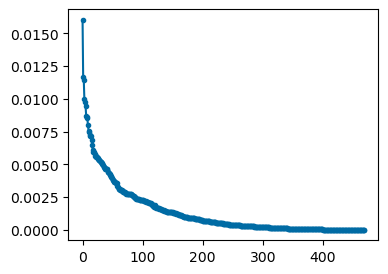

In [153]:
plt.plot(cl_qt_cf3_rg_a.weights,'.-')
plt.show()

In [154]:
cl_qt_cf3_outa={}
for i in range(len(cl_qt_cf3_rg_a.clusters)):
    cl_qt_cf3_outa[i,'lbl']=np.array(cl_qt_cf3_rg_a.clusters[i])
    cl_qt_cf3_outa[i,'size']=len(cl_qt_cf3_rg_a.clusters[i])
    cl_qt_cf3_outa[i,'weight']=cl_qt_cf3_rg_a.weights[i]

In [155]:
sizes_a=[]
weights_a=[]
for i in range(len(cl_qt_cf3_rg_a.clusters)):
    sizes_a.append(cl_qt_cf3_outa[i,'size'])
    weights_a.append(cl_qt_cf3_outa[i,'weight'])
sizes_a=np.array(sizes_a)
weights_a=np.array(weights_a)

In [156]:
# find centroids, taken from: https://mdtraj.org/1.9.3/examples/centroids.html
# ADAPTED with weights (mbernett)
centroids=[]
for i in range(50):
    cl=cl_qt_cf3_outa[i,'lbl'] # get cluster elements
    dists_i=mat_pca_rg_a[cl][:,cl] # subselect (from the full original mat) distance matrix for the cluster elements
    #
    beta = 1
    index = np.argmax(np.sum(np.exp(-beta*dists_i / dists_i.std())*weights_rg_a[cl],axis=1)) # index of centroid in the subselected mat
    centroids.append(cl[index]) # index of centroid in the original array
centroids=np.array(centroids)

In [157]:
# weighted average Rg of the clusters
cl_rgs_mb=[]
for i in range(50):
    cl_rgs_mb.append(np.average(colv_rew[frame_rg_a_int,5][cl_qt_cf3_outa[i,'lbl']],weights=weights_rg_a[cl_qt_cf3_outa[i,'lbl']])) # (should be) fixed

### 

In [158]:
# get centroids for rg_a group in the overall matrix mat_pca
# find centroids, taken from: https://mdtraj.org/1.9.3/examples/centroids.html
# ADAPTED with weights (mbernett)
centroids_a=[]
for i in range(len(cl_qt_cf3_rg_a.clusters)):
    cl=cl_qt_cf3_outa[i,'lbl'] # get cluster elements
    dists_i=mat_pca_rg_a[cl][:,cl] # subselect (from the full original mat) distance matrix for the cluster elements
    #
    beta = 1
    index = np.argmax(np.sum(np.exp(-beta*dists_i / dists_i.std())*weights_rg_a[cl],axis=1)) # index of centroid in the subselected mat
    centroids_a.append(cl[index]) # index of centroid in the original array
centroids_a=np.array(centroids_a)

/tmp/ipykernel_498599/1442363354.py:10: RuntimeWarning: invalid value encountered in divide
  index = np.argmax(np.sum(np.exp(-beta*dists_i / dists_i.std())*weights_rg_a[cl],axis=1)) # index of centroid in the subselected mat


In [159]:
# get centroids for rg_a group in the overall matrix mat_pca
# find centroids, taken from: https://mdtraj.org/1.9.3/examples/centroids.html
# ADAPTED with weights (mbernett)
centroids_b=[]
for i in range(len(cl_qt_cf3_rg_b.clusters)):
    cl=cl_qt_cf3_outb[i,'lbl'] # get cluster elements
    dists_i=mat_pca_rg_b[cl][:,cl] # subselect (from the full original mat) distance matrix for the cluster elements
    #
    beta = 1
    index = np.argmax(np.sum(np.exp(-beta*dists_i / dists_i.std())*weights_rg_b[cl],axis=1)) # index of centroid in the subselected mat
    centroids_b.append(cl[index]) # index of centroid in the original array
centroids_b=np.array(centroids_b)

/tmp/ipykernel_498599/1634802283.py:10: RuntimeWarning: invalid value encountered in divide
  index = np.argmax(np.sum(np.exp(-beta*dists_i / dists_i.std())*weights_rg_b[cl],axis=1)) # index of centroid in the subselected mat


In [160]:
cen_b=points_rg_b[centroids_b]

In [161]:
cen_a=points_rg_a[centroids_a]

In [162]:
cat_new=np.concatenate((cen_a,cen_b))

In [163]:
pickle.dump(cat_new,open(path_out+'concat_cen_a_b', "wb"))

In [164]:
cat_new=pickle.load(open(path_out+"concat_cen_a_b", "rb"))

In [165]:
mat_cen=sp.spatial.distance_matrix(cat_new,cat_new)

In [166]:
pickle.dump(mat_cen,open(path_out+'mat_centroidi_rg_a_b', "wb"))

In [167]:
mat_cen=pickle.load(open(path_out+"mat_centroidi_rg_a_b", "rb"))

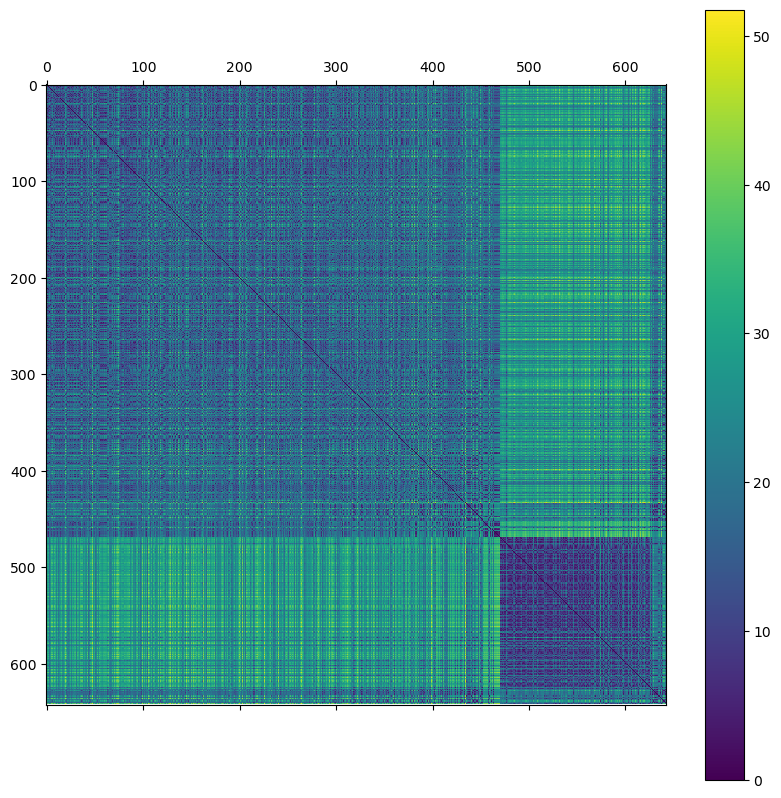

In [168]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(mat_cen, interpolation='nearest')
fig.colorbar(cax)

In [169]:
weights_a_b=cl_qt_cf3_rg_a.weights+cl_qt_cf3_rg_b.weights

In [170]:
weights_a_b_np=np.array(weights_a_b)

In [171]:
weights_a_b_norm=(weights_a_b_np-np.min(weights_a_b_np))/(np.max(weights_a_b_np)-np.min(weights_a_b_np))

In [172]:
weights_norm_sigm=250/(1+np.exp(-15*(weights_a_b_norm-0.5)))+1

In [173]:
color_a=[]
for cl in range(len(cl_qt_cf3_rg_a.clusters)):
    color_a.append('#8ecff5')

In [174]:
color_b=[]
for cl in range(len(cl_qt_cf3_rg_b.clusters)):
    color_b.append('#f5c18e')

In [175]:
g=net.Network(notebook=True, cdn_resources='remote')
label_a=[]
label_b=[]
for el in (range(len(cl_qt_cf3_rg_a.weights))):
    label_a.append('a'+str(el))
for el in (range(len(cl_qt_cf3_rg_b.weights))):
    label_b.append('b'+str(el))
    
g.add_nodes(range(len(cl_qt_cf3_rg_a.weights)), size=weights_norm_sigm[0:470],
                         color=color_a, label=label_a)
g.add_nodes(range(len(cl_qt_cf3_rg_a.weights),len(cl_qt_cf3_rg_a.weights)+len(cl_qt_cf3_rg_b.weights)), size=weights_norm_sigm[470:len(weights_norm_sigm)],
                         color=color_b, label=label_b)
for i in range(len(cat_new)):
    for j in range(len(cat_new)):
        if mat_cen[i,j]>5:
            pass
        else:
            if i==j:
                pass
            else:
                g.add_edge(i,j, width=1)
g.set_edge_smooth('dynamic')

g.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=95, spring_strength=0.03, damping=0.09, overlap=0)

g.show_buttons(filter_=['physics'])

g.save_graph(path_out+"network.html")